In [88]:
from pathlib import Path
import re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


DATA_DIR = Path(r"C:\\Users\\antoc\\lirmm\\picopatt-database\\dataproc\\")
OUTPUT_DIR = Path("./outputs"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUTPUT_DIR / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 200)


In [89]:
def strip_accents(s):
    if pd.isna(s): return s
    return ''.join(c for c in unicodedata.normalize('NFKD', str(s)) if not unicodedata.combining(c))

def normalize_track(x):
    if pd.isna(x): return np.nan
    x = strip_accents(str(x)).lower().strip()
    x = x.replace("boulevard", "boulevards")
    if "antigone" in x: return "antigone"
    if "boulevards" in x: return "boulevards"
    if "ecusson" in x: return "ecusson"
    return np.nan

def infer_track_from_filename(name: str):
    n = strip_accents(name.lower())
    if "antigone" in n:   return "antigone"
    if "boulevard" in n:  return "boulevards"
    if "ecusson" in n:    return "ecusson"
    return np.nan

def parse_fr_ts(s):
    return pd.to_datetime(s, errors="coerce", dayfirst=True)

def assign_M_slot(ts: pd.Timestamp):
    if pd.isna(ts): return np.nan
    h = int(ts.hour)
    if h in (8,9):   return "M1"
    if h in (11,12): return "M2"
    if h in (14,15): return "M3"
    if h in (17,18): return "M4"
    return np.nan


In [90]:
def read_any(p: Path) -> pd.DataFrame:
    if p.suffix.lower() in (".xlsx", ".xls"):
        df = pd.read_excel(p)
    else:
        for sep in [",",";","\t"]:
            try:
                df = pd.read_csv(p, sep=sep)
                if df.shape[1] >= 5: break
            except Exception:
                continue
    df["__source_file"] = p.name
    return df

def load_all(data_dir: Path):
    paths = sorted([p for p in data_dir.rglob("*") if p.suffix.lower() in (".csv",".xlsx",".xls")])
    assert paths, f"Aucun fichier trouvé dans {data_dir.resolve()}"
    frames = []
    for p in paths:
        df = read_any(p)

        # Renommage minimal
        rename = {"timestamp":"timestamp","track_id":"track_id",
                  "lon_rtk":"lon_rtk","lat_rtk":"lat_rtk",
                  "lon_ontrack":"lon_ontrack","lat_ontrack":"lat_ontrack"}
        df = df.rename(columns={c: rename.get(c, c) for c in df.columns})

        # Timestamp
        if "timestamp" in df.columns:
            df["timestamp"] = parse_fr_ts(df["timestamp"])

        # track_id: normalise + propage dans le fichier + fallback nom de fichier
        trk_file = infer_track_from_filename(p.name)
        if "track_id" not in df.columns:
            df["track_id"] = trk_file
        else:
            df["track_id"] = df["track_id"].map(normalize_track)  # garde NaN si manquant
            if df["track_id"].notna().any():
                df["track_id"] = df["track_id"].ffill().bfill()
            df["track_id"] = df["track_id"].fillna(trk_file)

        # GPS fusion
        for c in ["lon_rtk","lat_rtk","lon_ontrack","lat_ontrack"]:
            if c not in df.columns: df[c] = np.nan
        df["lon"] = df["lon_rtk"].where(df["lon_rtk"].notna(), df["lon_ontrack"])
        df["lat"] = df["lat_rtk"].where(df["lat_rtk"].notna(), df["lat_ontrack"])

        frames.append(df)

    data = pd.concat(frames, ignore_index=True, sort=False)
    return data

raw = load_all(DATA_DIR)
raw["M_slot"] = raw["timestamp"].map(assign_M_slot)
raw["date"] = raw["timestamp"].dt.date

print("Couverture:", raw["timestamp"].min(), "->", raw["timestamp"].max())
print("Parcours:", raw["track_id"].dropna().unique())
print(raw.pivot_table(index="track_id", columns="M_slot", values="timestamp", aggfunc="count").fillna(0).astype(int))


C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\344776039.py:22: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\344776039.py:22: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\344776039.py:22: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\344776039.py:22: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pa

Couverture: 2024-03-12 08:30:07 -> 2025-09-01 19:08:20
Parcours: ['antigone' 'boulevards' 'ecusson']
M_slot         M1     M2     M3     M4
track_id                              
antigone    27523  27190  29139  28923
boulevards  21279  28399  18017  24694
ecusson     19761  20945  17813  15822


In [91]:
print("Couverture temporelle:", raw["timestamp"].min(), "->", raw["timestamp"].max())
print("Parcours dispo:", raw["track_id"].dropna().unique())

missing = raw.isna().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes (top 20) :")
display(missing.head(20))

print("Comptage par parcours :")
display(raw["track_id"].value_counts())

raw["passage_slot"] = raw["M_slot"]
print("Comptage par parcours x passage :")
display(raw.pivot_table(index="track_id", columns="passage_slot", values="timestamp", aggfunc="count").fillna(0).astype(int))


Couverture temporelle: 2024-03-12 08:30:07 -> 2025-09-01 19:08:20
Parcours dispo: ['antigone' 'boulevards' 'ecusson']
Taux de valeurs manquantes (top 20) :


project_id          0.999786
section_warning     0.999660
section_speed       0.988983
section_weather     0.988983
section_duration    0.988983
M_slot              0.181012
gnss_accuracy       0.000006
lat_rtk             0.000006
lon_rtk             0.000006
section_id          0.000000
track_id            0.000000
timestamp           0.000000
segment_id          0.000000
point_id            0.000000
lat_ontrack         0.000000
sun_azimuth         0.000000
sun_height          0.000000
tair_thermohygro    0.000000
lon_ontrack         0.000000
tair_tc2            0.000000
dtype: float64

Comptage par parcours :


track_id
antigone      121457
boulevards    115962
ecusson       103862
Name: count, dtype: int64

Comptage par parcours x passage :


passage_slot,M1,M2,M3,M4
track_id,,,,
antigone,27523,27190,29139,28923
boulevards,21279,28399,18017,24694
ecusson,19761,20945,17813,15822


In [92]:
# variables météo (présence testée)
CANDIDATES = [
    "tair_thermohygro","tair_tc1","tair_tc2","tair_anemo",
    "rh_thermohygro","ws","wdir",
    "sw_up","sw_down","sw_front","sw_back","sw_left","sw_right",
    "lw_up","lw_down","lw_front","lw_back","lw_left","lw_right",
    "tmrt","pet"
]
METEO = [c for c in CANDIDATES if c in raw.columns]
num_cols = [c for c in METEO if c != "wdir"]

def summary_stats(df, cols):
    q = df[cols].quantile([.10,.25,.50,.75,.90], numeric_only=True).T
    out = pd.DataFrame({
        "count": df[cols].count(),
        "na_pct": df[cols].isna().mean()*100,
        "mean": df[cols].mean(numeric_only=True),
        "std": df[cols].std(numeric_only=True),
        "min": df[cols].min(numeric_only=True),
        "p10": q[.10], "p25": q[.25], "median": q[.50], "p75": q[.75], "p90": q[.90],
        "max": df[cols].max(numeric_only=True),
    })
    return out

def circular_mean_deg(s):
    r = np.deg2rad(s.dropna().astype(float) % 360.0)
    if r.size == 0: return np.nan
    ang = np.arctan2(np.sin(r).mean(), np.cos(r).mean())
    return np.rad2deg(ang) % 360.0

# Global
stats_global = summary_stats(raw, num_cols)
if "wdir" in METEO: stats_global.loc["wdir","mean"] = circular_mean_deg(raw["wdir"])
stats_global.to_csv("outputs/stats_global.xlsx")
display(stats_global)

# Par parcours
by_track = []
for t,g in raw.groupby("track_id", dropna=True):
    s = summary_stats(g, num_cols)
    if "wdir" in METEO: s.loc["wdir","mean"] = circular_mean_deg(g["wdir"])
    s.insert(0,"track_id",t)
    by_track.append(s.reset_index(names="variable"))
stats_by_track = pd.concat(by_track, ignore_index=True)
stats_by_track.to_csv("outputs/stats_par_parcours.xlsx", index=False)
display(stats_by_track.head())

# Par parcours x M_slot (M1..M4)
def agg_means(g):
    res = {f"{c}_mean": g[c].mean() for c in num_cols}
    if "wdir" in METEO: res["wdir_mean_circ"] = circular_mean_deg(g["wdir"])
    return pd.Series(res)

stats_track_M = raw.groupby(["track_id","M_slot"]).apply(agg_means).reset_index()
stats_track_M.to_excel(OUTPUT_DIR / "stats_parcours_par_Mslot.xlsx", index=False)
display(stats_track_M.head())


,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
tair_thermohygro,341281.0,0.0,12.322580,4.446766,-0.971618,6.489281,9.496071,12.129015,15.034333,17.880903,25.053407
tair_tc1,341281.0,0.0,20.773164,130.146941,0.007812,6.398438,9.359375,12.000000,15.023438,18.007812,2047.992188
tair_tc2,341281.0,0.0,13.612225,53.550689,0.000000,6.398438,9.382812,11.953125,14.867188,17.914062,2047.992188
tair_anemo,341281.0,0.0,14.543863,4.822161,1.000000,8.000000,11.000000,15.000000,17.000000,20.000000,30.000000
rh_thermohygro,341281.0,0.0,60.532089,12.035269,37.474861,45.279850,51.145037,58.829862,69.543603,78.094377,87.657969
ws,341281.0,0.0,1.047698,0.877630,0.000000,0.154333,0.463000,0.874555,1.388999,2.109220,11.009102
sw_up,341281.0,0.0,49.782584,85.554051,0.000000,0.000000,0.000000,19.431816,54.280126,123.396639,712.930225
sw_down,341281.0,0.0,7.090579,22.537950,0.000000,0.000000,0.000000,0.000000,0.000000,18.696829,341.675115
sw_front,341281.0,0.0,54.993113,104.226845,3.323424,14.277620,15.882575,26.655764,47.904116,89.354224,984.895425
sw_back,341281.0,0.0,37.628652,84.803999,0.000000,4.113576,5.483859,15.175765,33.960958,68.835741,866.605546


,variable,track_id,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
0,tair_thermohygro,antigone,121457.0,0.0,14.245584,4.113195,5.629435,9.148928,10.510796,14.585718,17.122530,19.531167,24.433890
1,tair_tc1,antigone,121457.0,0.0,14.160871,4.162505,5.390625,8.957813,10.570312,14.429688,17.078125,19.304688,25.828125
2,tair_tc2,antigone,121457.0,0.0,14.132794,4.132840,5.367188,9.015625,10.570312,14.359375,17.078125,19.304688,25.242188
3,tair_anemo,antigone,121457.0,0.0,16.576262,4.666686,7.000000,11.000000,12.000000,16.000000,20.000000,23.000000,29.000000
4,rh_thermohygro,antigone,121457.0,0.0,68.086875,11.272769,41.478447,52.453498,59.320058,67.802167,77.813993,83.217594,87.657969


C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\4075834404.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_track_M = raw.groupby(["track_id","M_slot"]).apply(agg_means).reset_index()


,track_id,M_slot,tair_thermohygro_mean,tair_tc1_mean,tair_tc2_mean,tair_anemo_mean,rh_thermohygro_mean,ws_mean,sw_up_mean,sw_down_mean,sw_front_mean,sw_back_mean,sw_left_mean,sw_right_mean,lw_up_mean,lw_down_mean,lw_front_mean,lw_back_mean,lw_left_mean,lw_right_mean,tmrt_mean,pet_mean,wdir_mean_circ
0,antigone,M1,11.206787,11.117618,11.131297,13.058678,78.422463,0.863910,48.717718,5.793217,58.219302,37.896765,34.566215,65.509012,362.681335,388.799583,385.358779,384.648711,389.414901,383.616588,19.529653,10.842659,358.725688
1,antigone,M2,15.129053,15.161173,15.071895,18.481574,66.763626,1.057348,159.649272,29.662831,127.627909,91.995504,89.134463,135.408363,371.469616,407.440311,401.253437,400.909044,405.522931,399.788278,29.278455,16.860707,2.255707
2,antigone,M3,16.279904,16.194290,16.129487,18.773259,60.591832,1.335369,78.525242,12.325536,86.710713,55.956563,49.966215,94.537516,367.484429,409.730696,401.963662,401.287310,406.065283,400.585606,24.892820,15.591107,358.371773
3,antigone,M4,14.053747,13.872983,13.893078,15.743353,66.975029,1.213080,0.000000,0.000000,14.096395,3.490550,0.000000,20.221727,361.450661,398.289151,391.976673,390.147111,396.268693,390.502187,16.004968,11.282775,357.249837
4,boulevards,M1,7.660576,7.333193,7.387541,9.680154,66.522219,0.928148,26.369243,2.584970,45.997436,22.644936,10.441044,48.432405,346.833615,371.135947,368.229251,365.902906,372.183546,369.128134,14.515659,6.703842,6.154562


In [93]:
# Global (numériques hors wdir)
num_cols = [c for c in METEO if c != "wdir"]
stats_global = summary_stats(raw, num_cols)
if "wdir" in METEO:
    stats_global.loc["wdir","mean"] = circular_mean_deg(raw["wdir"])
display(stats_global)
stats_global.to_excel(OUTPUT_DIR / "stats_global.xlsx")

# Par parcours
by_track = []
for t, g in raw.groupby("track_id"):
    tmp = summary_stats(g, num_cols)
    if "wdir" in METEO:
        tmp.loc["wdir","mean"] = circular_mean_deg(g["wdir"])
    tmp.insert(0, "track_id", t)
    by_track.append(tmp.reset_index(names="variable"))
stats_by_track = pd.concat(by_track, ignore_index=True)
display(stats_by_track.head())
stats_by_track.to_excel(OUTPUT_DIR / "stats_par_parcours.xlsx", index=False)


,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
tair_thermohygro,341281.0,0.0,12.322580,4.446766,-0.971618,6.489281,9.496071,12.129015,15.034333,17.880903,25.053407
tair_tc1,341281.0,0.0,20.773164,130.146941,0.007812,6.398438,9.359375,12.000000,15.023438,18.007812,2047.992188
tair_tc2,341281.0,0.0,13.612225,53.550689,0.000000,6.398438,9.382812,11.953125,14.867188,17.914062,2047.992188
tair_anemo,341281.0,0.0,14.543863,4.822161,1.000000,8.000000,11.000000,15.000000,17.000000,20.000000,30.000000
rh_thermohygro,341281.0,0.0,60.532089,12.035269,37.474861,45.279850,51.145037,58.829862,69.543603,78.094377,87.657969
ws,341281.0,0.0,1.047698,0.877630,0.000000,0.154333,0.463000,0.874555,1.388999,2.109220,11.009102
sw_up,341281.0,0.0,49.782584,85.554051,0.000000,0.000000,0.000000,19.431816,54.280126,123.396639,712.930225
sw_down,341281.0,0.0,7.090579,22.537950,0.000000,0.000000,0.000000,0.000000,0.000000,18.696829,341.675115
sw_front,341281.0,0.0,54.993113,104.226845,3.323424,14.277620,15.882575,26.655764,47.904116,89.354224,984.895425
sw_back,341281.0,0.0,37.628652,84.803999,0.000000,4.113576,5.483859,15.175765,33.960958,68.835741,866.605546


,variable,track_id,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
0,tair_thermohygro,antigone,121457.0,0.0,14.245584,4.113195,5.629435,9.148928,10.510796,14.585718,17.122530,19.531167,24.433890
1,tair_tc1,antigone,121457.0,0.0,14.160871,4.162505,5.390625,8.957813,10.570312,14.429688,17.078125,19.304688,25.828125
2,tair_tc2,antigone,121457.0,0.0,14.132794,4.132840,5.367188,9.015625,10.570312,14.359375,17.078125,19.304688,25.242188
3,tair_anemo,antigone,121457.0,0.0,16.576262,4.666686,7.000000,11.000000,12.000000,16.000000,20.000000,23.000000,29.000000
4,rh_thermohygro,antigone,121457.0,0.0,68.086875,11.272769,41.478447,52.453498,59.320058,67.802167,77.813993,83.217594,87.657969


In [94]:
tracks_focus = ["antigone","boulevards","ecusson"]
sub = raw[raw["track_id"].isin(tracks_focus)]

def means_with_circ(df):
    m = df[num_cols].mean(numeric_only=True)
    if "wdir" in METEO: m["wdir"] = circular_mean_deg(df["wdir"])
    return m

comp = sub.groupby("track_id").apply(means_with_circ).T[tracks_focus]
comp.to_excel(OUTPUT_DIR / "comparaison_parcours_moyennes.xlsx")
display(comp)

# Version par M_slot (colonnes multi-index -> plus lisible en CSV)
comp_M = sub.groupby(["track_id","M_slot"]).apply(means_with_circ).unstack(0)
comp_M.to_excel(OUTPUT_DIR / "comparaison_parcours_moyennes_par_Mslot.xlsx")
display(comp_M.head())


C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\3457922614.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp = sub.groupby("track_id").apply(means_with_circ).T[tracks_focus]


track_id,antigone,boulevards,ecusson
tair_thermohygro,14.245584,11.163543,11.367870
tair_tc1,14.160871,10.977110,39.442929
tair_tc2,14.132794,10.963355,15.960933
tair_anemo,16.576262,13.459711,13.377616
rh_thermohygro,68.086875,57.453884,55.134283
ws,1.115083,1.045507,0.971342
sw_up,69.503826,46.714374,30.146077
sw_down,11.197564,7.007464,2.380638
sw_front,68.891622,58.096344,35.275333
sw_back,46.576064,40.772402,23.655480


C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\3457922614.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_M = sub.groupby(["track_id","M_slot"]).apply(means_with_circ).unstack(0)


tair_thermohygro                         tair_tc1             \
track_id         antigone boulevards    ecusson   antigone boulevards   
M_slot                                                                  
M1              11.206787   7.660576   8.942756  11.117618   7.333193   
M2              15.129053  12.468959  12.303107  15.161173  12.430946   
M3              16.279904  13.794220  12.728330  16.194290  13.642063   
M4              14.053747  10.998848   9.985556  13.872983  10.721545   

                       tair_tc2                       tair_anemo             \
track_id     ecusson   antigone boulevards    ecusson   antigone boulevards   
M_slot                                                                        
M1        157.011741  11.131297   7.387541  33.758839  13.058678   9.680154   
M2         12.253836  15.071895  12.345501  12.098766  18.481574  15.458361   
M3         12.552635  16.129487  13.572954  12.519115  18.773259  16.339291   
M4          9.795978  13.893078  10.765054   9.867012  15.743353  12.755973   

                    rh_thermohygro                              ws             \
track_id    ecusson       antigone boulevards    ecusson  antigone boulevards   
M_slot                                                                          
M1        10.636152      78.422463  66.522219  61.346927  0.863910   0.928148   
M2        14.524660      66.763626  54.042821  49.982398  1.057348   1.395283   
M3        15.191265      60.591832  46.796228  47.102115  1.335369   0.964854   
M4        11.687018      66.975029  61.912273  62.375603  1.213080   0.773633   

                         sw_up                           sw_down             \
track_id   ecusson    antigone  boulevards    ecusson   antigone boulevards   
M_slot                                                                        
M1        0.801339   48.717718   26.369243  13.970999   5.793217   2.584970   
M2        1.080622  159.649272  114.493248  58.133573  29.662831  21.408082   
M3        0.970403   78.525242   60.004809  38.552957  12.325536   7.053701   
M4        0.935620    0.000000    0.000000   0.000923   0.000000   0.000000   

                      sw_front                           sw_back             \
track_id   ecusson    antigone  boulevards    ecusson   antigone boulevards   
M_slot                                                                        
M1        0.534858   58.219302   45.997436  25.328798  37.896765  22.644936   
M2        4.487317  127.627909  115.024761  48.094146  91.995504  95.034469   
M3        2.492398   86.710713   85.115316  36.355007  55.956563  47.528284   
M4        0.000000   14.096395   14.390278  14.111957   3.490550   4.282521   

                       sw_left                          sw_right             \
track_id    ecusson   antigone boulevards    ecusson    antigone boulevards   
M_slot                                                                        
M1        14.380907  34.566215  10.441044   3.153325   65.509012  48.432405   
M2        38.068097  89.134463  58.092279  19.104413  135.408363  98.982542   
M3        35.804812  49.966215  29.433111  15.479199   94.537516  62.543484   
M4         3.541104   0.000000   0.000000   0.000000   20.221727  20.652887   

                          lw_up                             lw_down  \
track_id    ecusson    antigone  boulevards     ecusson    antigone   
M_slot                                                                
M1        31.271939  362.681335  346.833615  362.012677  388.799583   
M2        57.594965  371.469616  348.870487  373.189963  407.440311   
M3        48.892422  367.484429  357.706960  371.742765  409.730696   
M4        20.423225  361.450661  353.315464  369.428606  398.289151   

                                    lw_front                          \
track_id  boulevards     ecusson    antigone  boulevards     ecusson   
M_slot                                                                 

In [95]:
# moyenne par parcours x passage_slot
def agg_fun(g):
    out = {}
    for c in num_cols:
        out[c+"_mean"] = g[c].mean()
        out[c+"_median"] = g[c].median()
    if "wdir" in METEO:
        out["wdir_mean_circ"] = circular_mean_deg(g["wdir"])
    return pd.Series(out)

stats_track_passage = raw.groupby(["track_id","passage_slot"]).apply(agg_fun).reset_index()
display(stats_track_passage)
stats_track_passage.to_excel(OUTPUT_DIR / "stats_parcours_par_passage.xlsx", index=False)


C:\Users\antoc\AppData\Local\Temp\ipykernel_8376\2394212816.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_track_passage = raw.groupby(["track_id","passage_slot"]).apply(agg_fun).reset_index()


,track_id,passage_slot,tair_thermohygro_mean,tair_thermohygro_median,tair_tc1_mean,tair_tc1_median,tair_tc2_mean,tair_tc2_median,tair_anemo_mean,tair_anemo_median,rh_thermohygro_mean,rh_thermohygro_median,ws_mean,ws_median,sw_up_mean,sw_up_median,sw_down_mean,sw_down_median,sw_front_mean,sw_front_median,sw_back_mean,sw_back_median,sw_left_mean,sw_left_median,sw_right_mean,sw_right_median,lw_up_mean,lw_up_median,lw_down_mean,lw_down_median,lw_front_mean,lw_front_median,lw_back_mean,lw_back_median,lw_left_mean,lw_left_median,lw_right_mean,lw_right_median,tmrt_mean,tmrt_median,pet_mean,pet_median,wdir_mean_circ
0,antigone,M1,11.206787,9.709697,11.117618,9.625000,11.131297,9.671875,13.058678,12.0,78.422463,79.959792,0.863910,0.823110,48.717718,29.365157,5.793217,0.000000,58.219302,32.354190,37.896765,18.491788,34.566215,7.902942,65.509012,37.859535,362.681335,363.033753,388.799583,381.445430,385.358779,381.320419,384.648711,381.377409,389.414901,385.355518,383.616588,379.747035,19.529653,15.899973,10.842659,9.318879,358.725688
1,antigone,M2,15.129053,14.991608,15.161173,15.023438,15.071895,14.648438,18.481574,19.0,66.763626,66.943847,1.057348,0.977444,159.649272,102.973417,29.662831,10.146091,127.627909,70.930541,91.995504,52.283107,89.134463,48.466318,135.408363,73.914154,371.469616,371.317549,407.440311,399.534668,401.253437,396.323706,400.909044,395.889982,405.522931,399.932793,399.788278,394.816819,29.278455,24.973208,16.860707,15.226830,2.255707
2,antigone,M3,16.279904,15.958267,16.194290,15.890625,16.129487,15.882812,18.773259,19.0,60.591832,59.835050,1.335369,1.080332,78.525242,54.587744,12.325536,0.306412,86.710713,47.948820,55.956563,34.545951,49.966215,22.222741,94.537516,52.359981,367.484429,370.465953,409.730696,404.594690,401.963662,399.581289,401.287310,398.325230,406.065283,404.053082,400.585606,398.133425,24.892820,21.994276,15.591107,13.723872,358.371773
3,antigone,M4,14.053747,14.222553,13.872983,14.078125,13.893078,14.085938,15.743353,16.0,66.975029,63.850080,1.213080,0.823110,0.000000,0.000000,0.000000,0.000000,14.096395,14.427071,3.490550,4.202142,0.000000,0.000000,20.221727,20.629417,361.450661,361.058075,398.289151,393.723386,391.976673,389.051568,390.147111,387.175416,396.268693,392.885583,390.502187,387.741452,16.004968,15.448150,11.282775,10.644625,357.249837
4,boulevards,M1,7.660576,7.803082,7.333193,7.562500,7.387541,7.632812,9.680154,10.0,66.522219,67.960479,0.928148,0.720222,26.369243,12.155650,2.584970,0.000000,45.997436,23.107944,22.644936,11.442799,10.441044,0.000000,48.432405,26.897837,346.833615,348.333499,371.135947,371.285462,368.229251,369.274107,365.902906,366.465739,372.183546,374.211569,369.128134,371.363638,14.515659,13.406846,6.703842,6.200501,6.154562
5,boulevards,M2,12.468959,12.129015,12.430946,12.062500,12.345501,12.015625,15.458361,15.0,54.042821,53.582666,1.395283,1.080332,114.493248,58.813002,21.408082,0.838924,115.024761,57.203393,95.034469,35.719118,58.092279,28.625726,98.982542,50.248323,348.870487,351.912074,388.144278,387.275422,382.573733,382.740887,382.564721,381.626918,388.859559,389.033078,384.580111,385.226051,24.188712,19.896619,12.433204,11.341008,4.504606
6,boulevards,M3,13.794220,13.629740,13.642063,13.554688,13.572954,13.539062,16.339291,16.0,46.796228,46.164874,0.964854,0.823110,60.004809,36.521361,7.053701,0.000000,85.115316,39.918344,47.528284,29.822402,29.433111,17.589185,62.543484,40.399954,357.706960,360.029557,393.827844,393.042439,388.986783,388.310854,387.951103,387.232266,394.555668,395.338094,390.706583,391.748117,21.239010,19.265050,13.057286,12.414780,2.949620
7,boulevards,M4,10.998848,10.916686,10.721545,10.414062,10.765054,10.500000,12.755973,12.0,61.912273,59.960937,0.773633,0.720222,0.000000,0.000000,0.000000,0.000000,14.390278,14.453367,4.282521,4.301609,0.000000,0.000000,20.652887,20.680579,353.315464,355.865660,383.866415,382.970096,379.614265,380.146626,377.138851,376.867021,384.549191,385.051551,381.010994,382.188355,13.951566,14.107990,8.859926

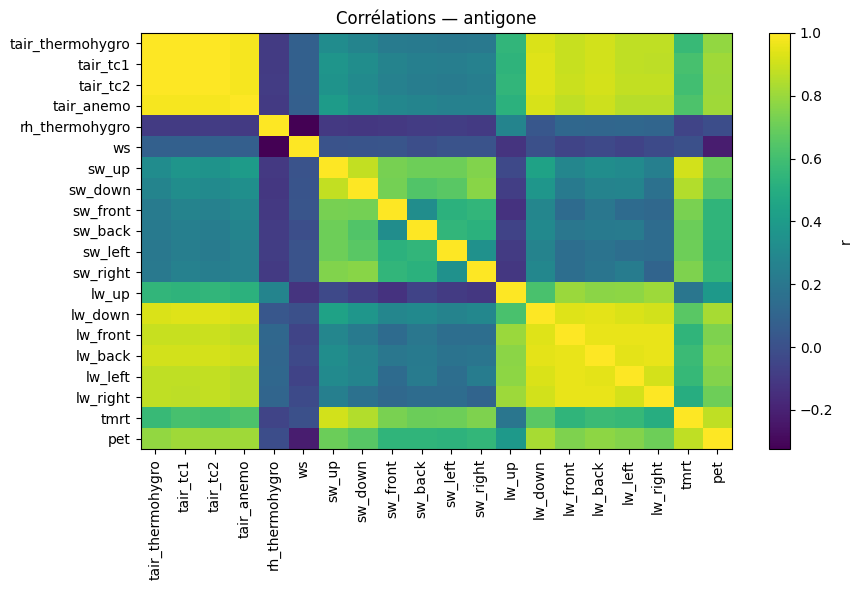

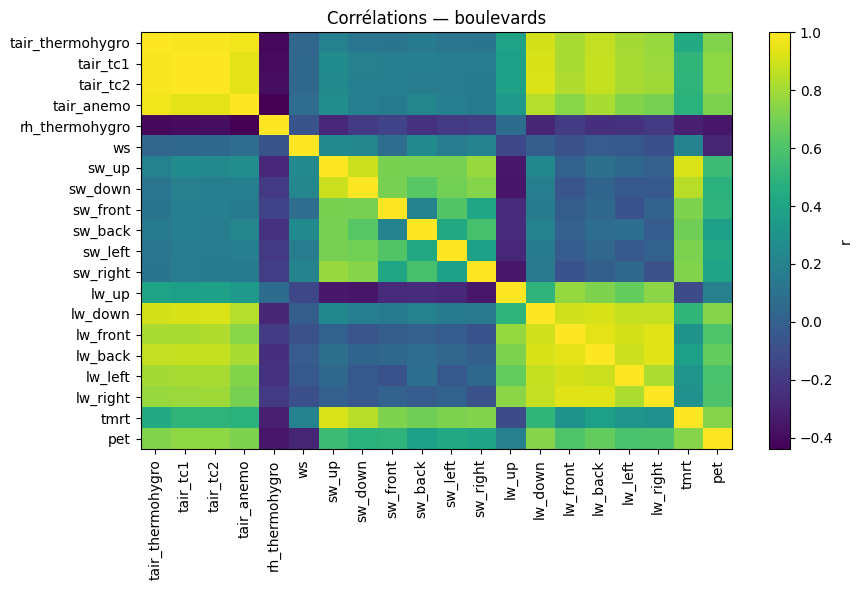

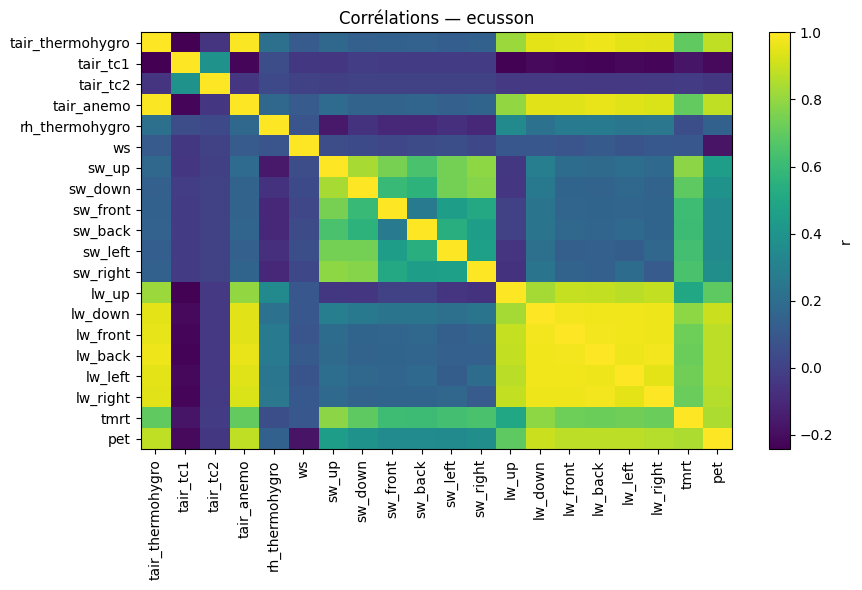

In [96]:
for t, g in raw.groupby("track_id"):
    sel = g[num_cols].select_dtypes(include=[np.number]).dropna(how="all", axis=1)
    if sel.shape[1] < 2: 
        print(f"Parcours {t}: pas assez de colonnes numériques pour corrélation.")
        continue
    corr = sel.corr()
    plt.figure(figsize=(9,6))
    plt.title(f"Corrélations — {t}")
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(label="r")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"corr_{t}.png", dpi=150)
    plt.show()


<Figure size 700x400 with 0 Axes>

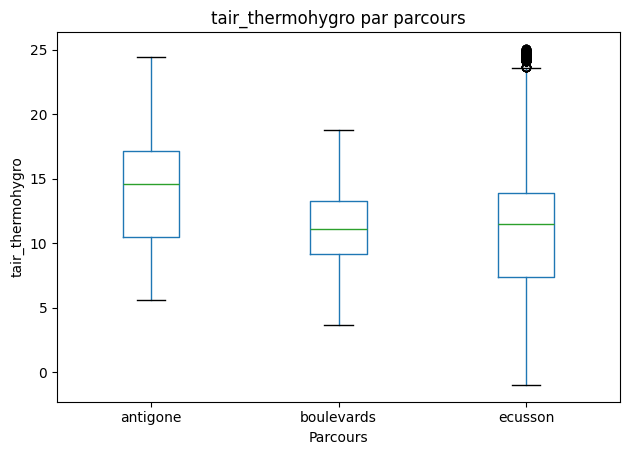

<Figure size 700x400 with 0 Axes>

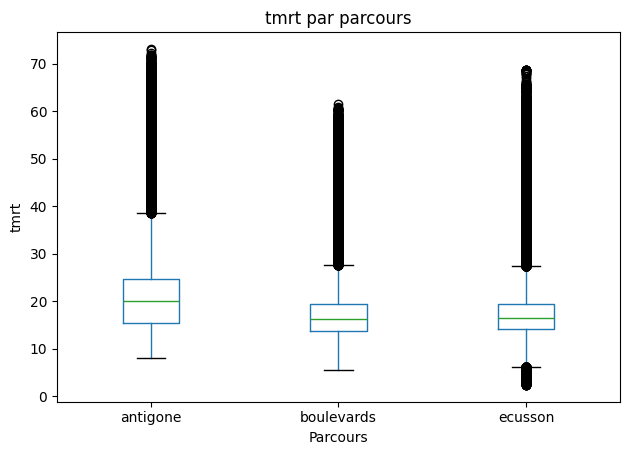

<Figure size 700x400 with 0 Axes>

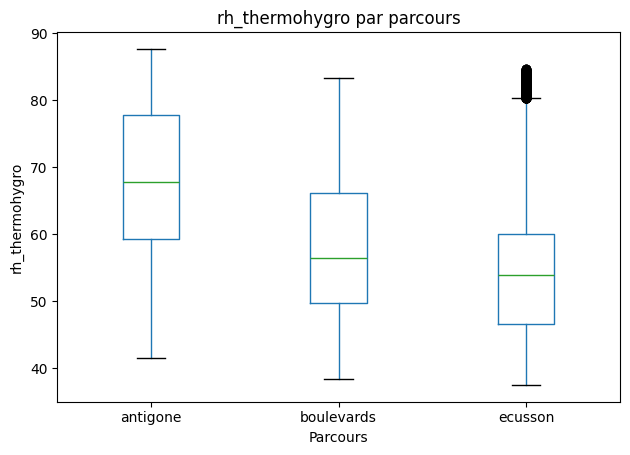

<Figure size 700x400 with 0 Axes>

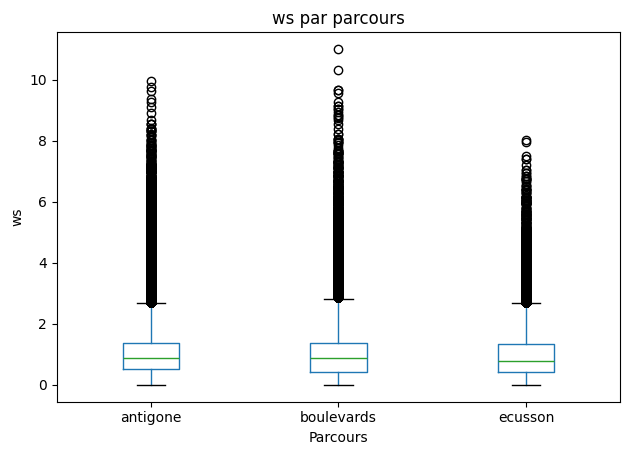

<Figure size 700x400 with 0 Axes>

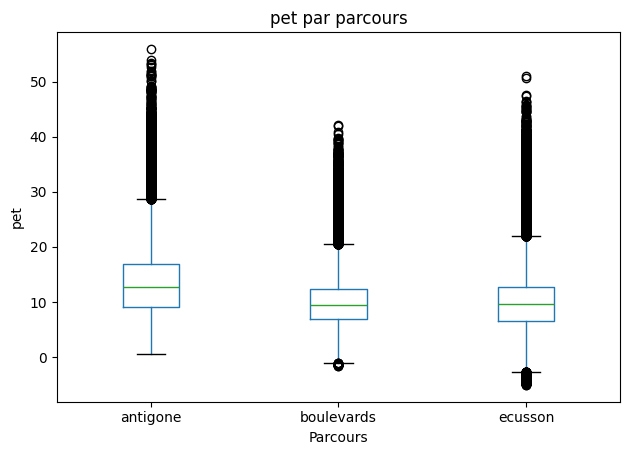

In [97]:
vars_plot = [v for v in ["tair_thermohygro","tmrt","rh_thermohygro","ws","pet"] if v in METEO]
for v in vars_plot:
    plt.figure(figsize=(7,4))
    raw.boxplot(column=v, by="track_id", grid=False)
    plt.title(f"{v} par parcours")
    plt.suptitle("")
    plt.xlabel("Parcours"); plt.ylabel(v)
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"box_{v}_parcours.png", dpi=150)
    plt.show()


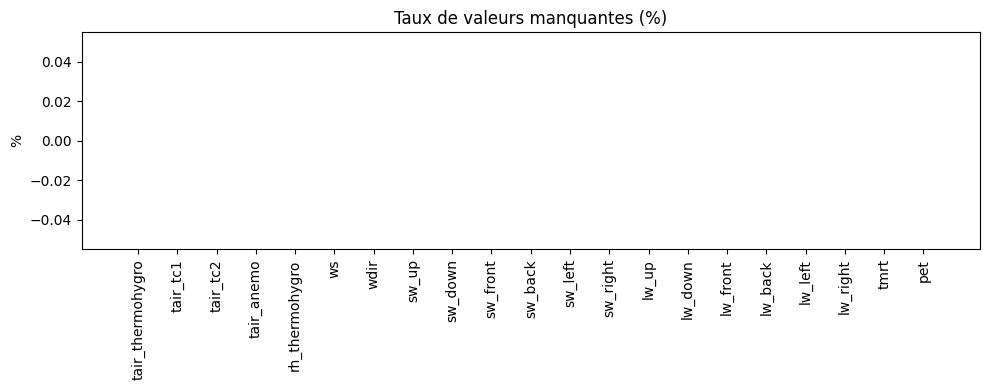

In [98]:
na = raw[METEO].isna().mean().sort_values(ascending=False)*100
plt.figure(figsize=(10,4))
plt.bar(na.index, na.values)
plt.title("Taux de valeurs manquantes (%)")
plt.xticks(rotation=90); plt.ylabel("%")
plt.tight_layout(); plt.savefig(FIG_DIR/"na_pct_vars.png", dpi=150); plt.show()


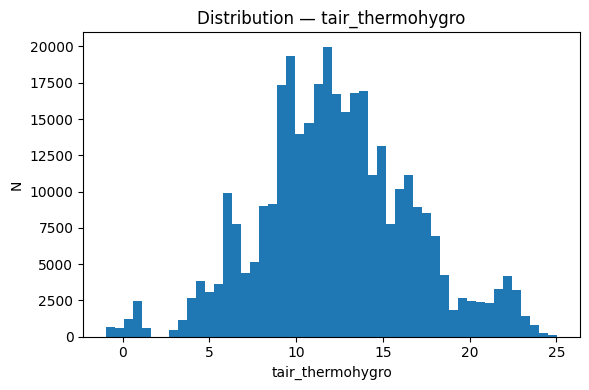

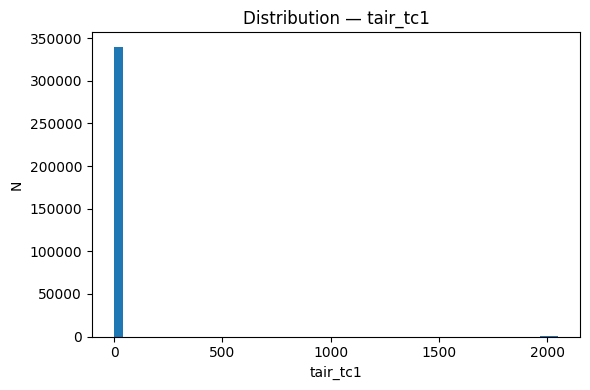

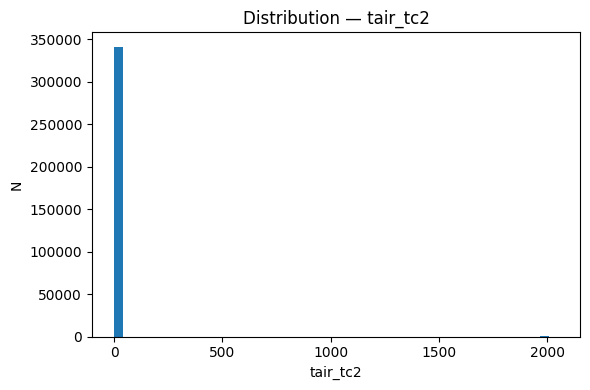

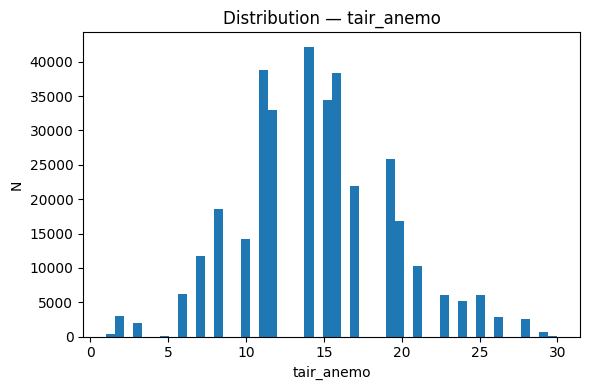

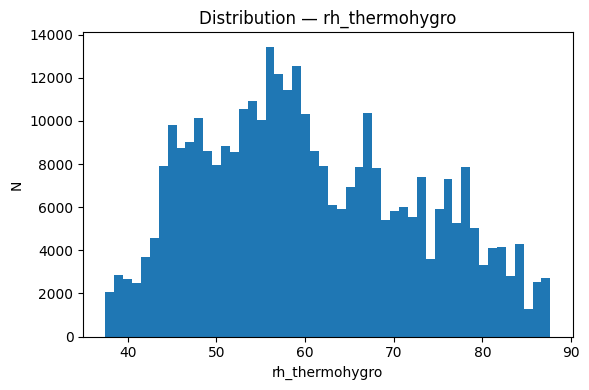

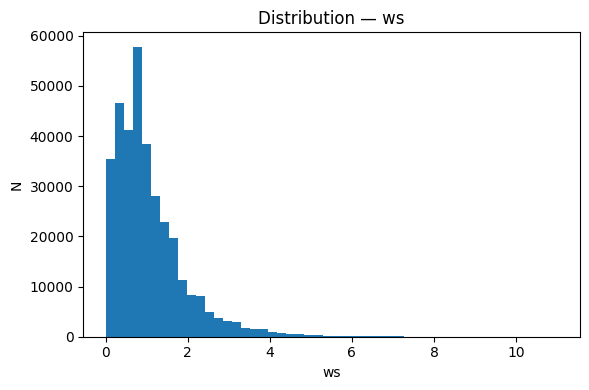

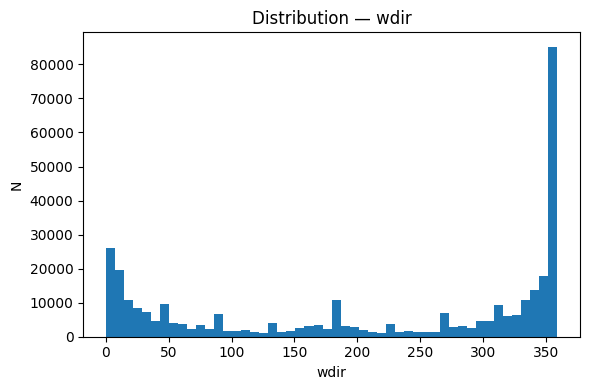

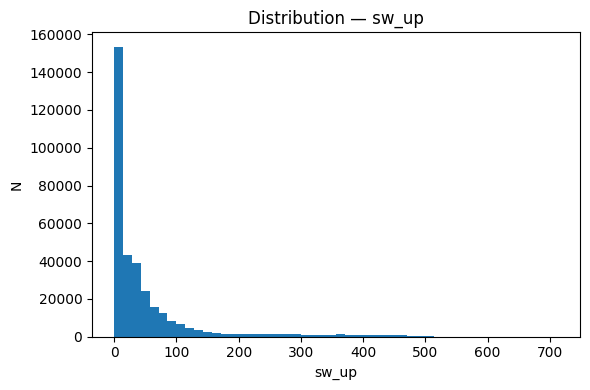

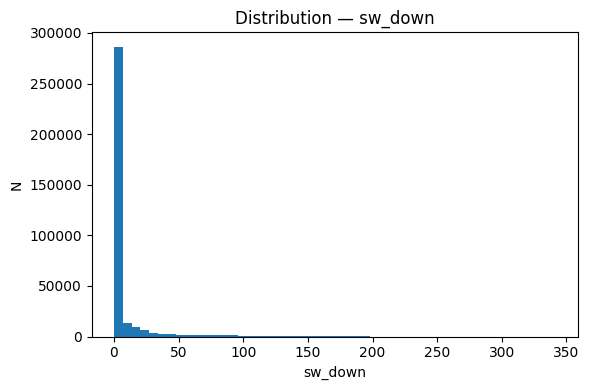

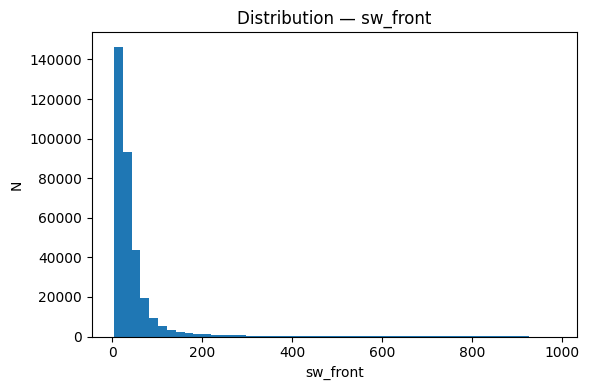

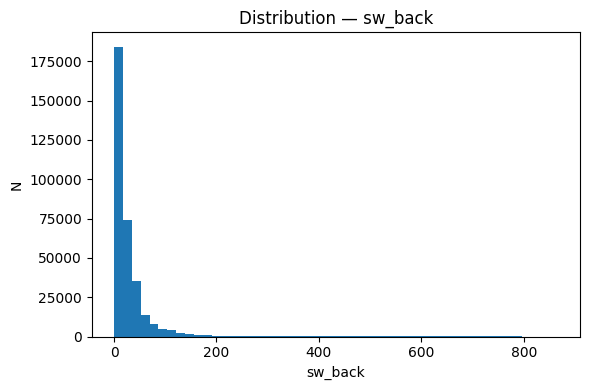

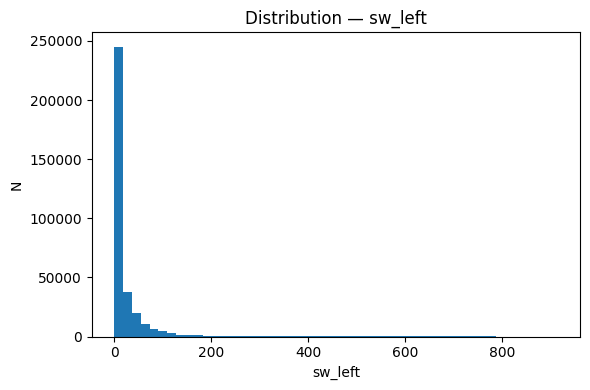

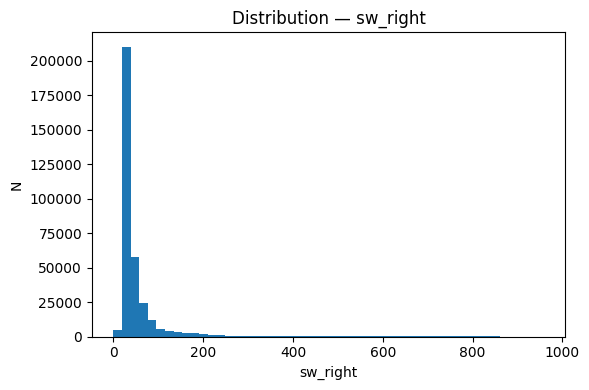

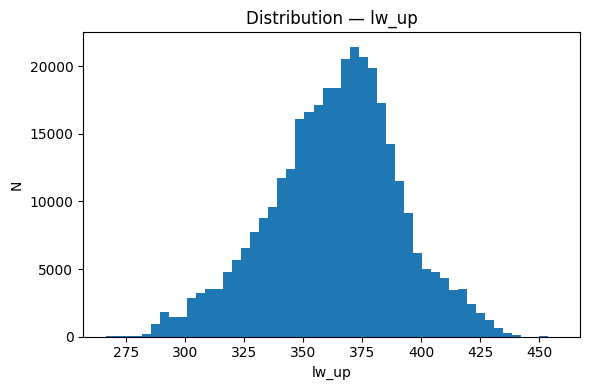

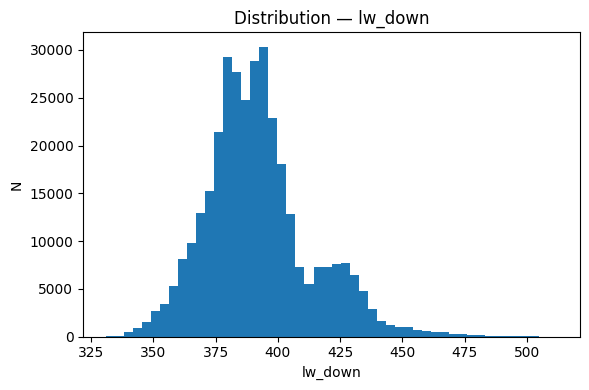

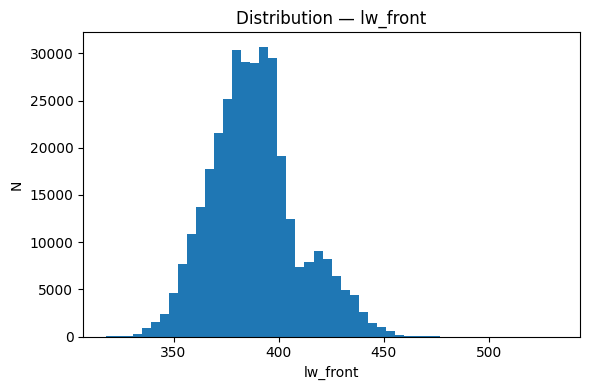

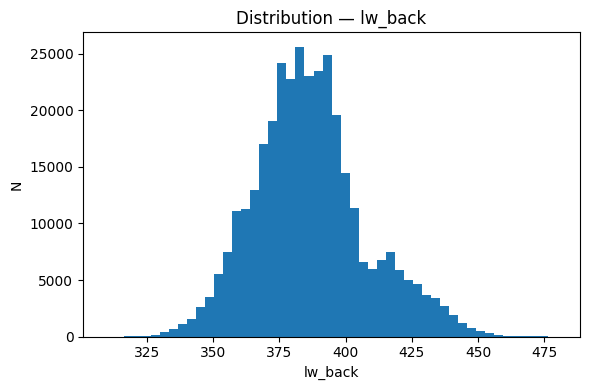

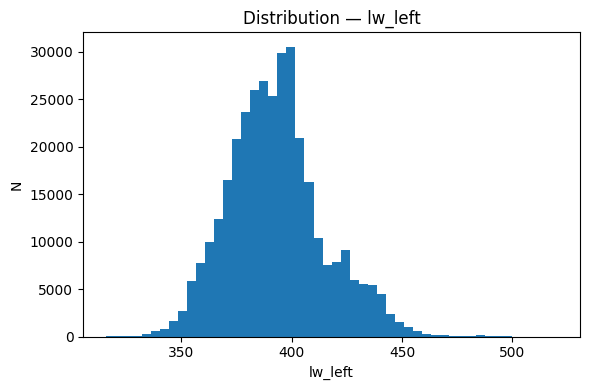

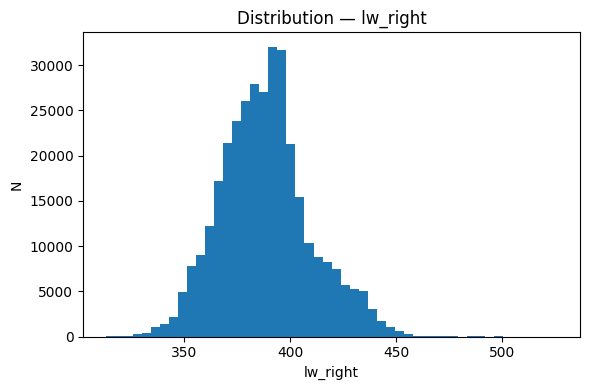

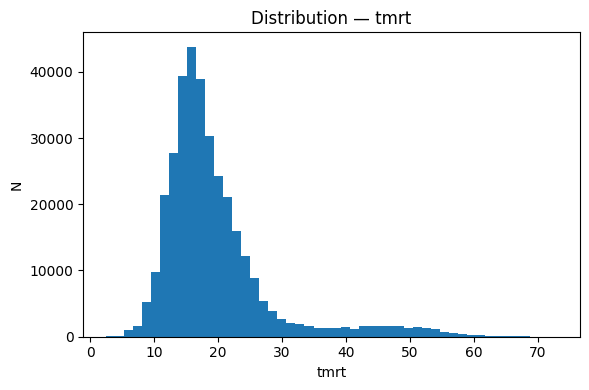

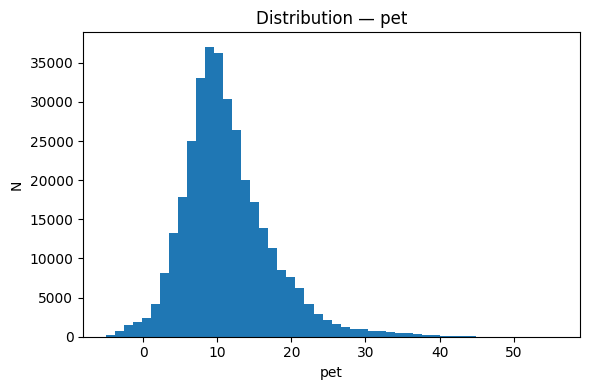

In [99]:
for v in METEO:
    s = raw[v].dropna()
    if len(s)==0: continue
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=50)
    plt.title(f"Distribution — {v}")
    plt.xlabel(v); plt.ylabel("N")
    plt.tight_layout(); plt.savefig(FIG_DIR/f"dist_global_{v}.png", dpi=150); plt.show()


<Figure size 700x400 with 0 Axes>

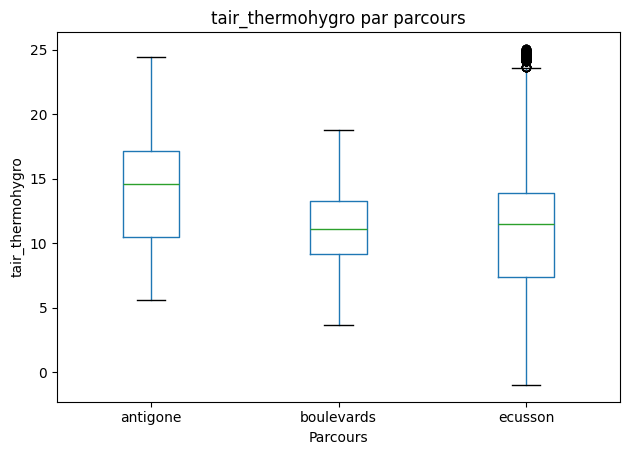

<Figure size 700x400 with 0 Axes>

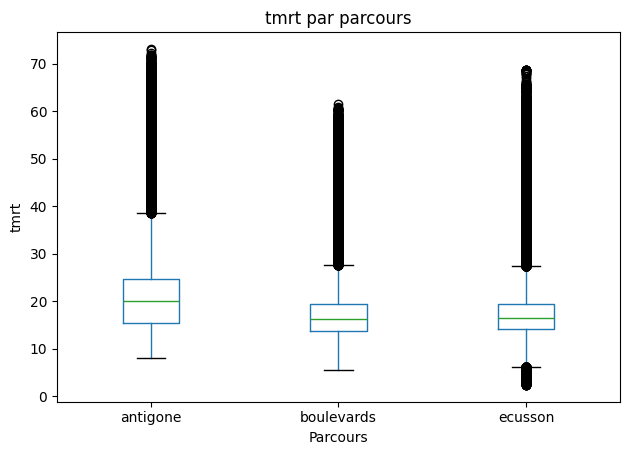

<Figure size 700x400 with 0 Axes>

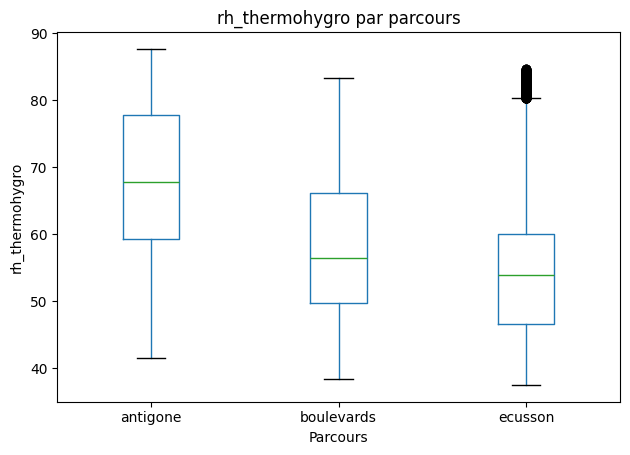

<Figure size 700x400 with 0 Axes>

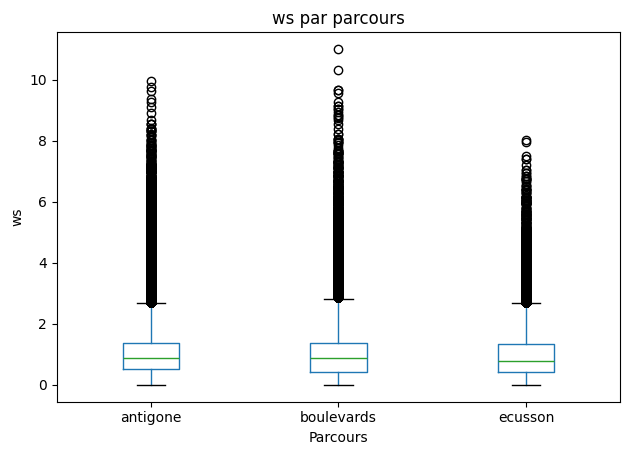

<Figure size 700x400 with 0 Axes>

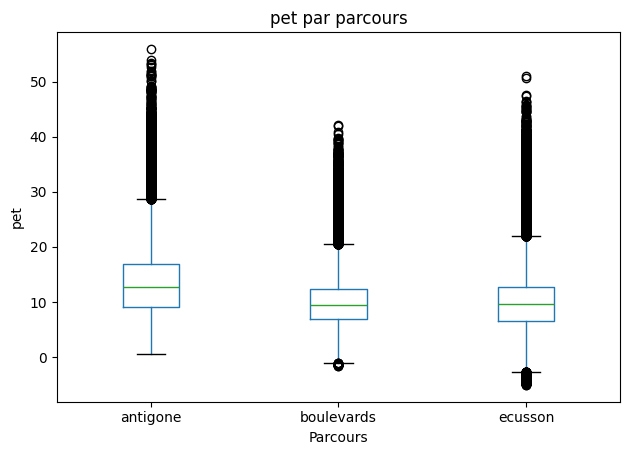

In [100]:
for v in [x for x in ["tair_thermohygro","tmrt","rh_thermohygro","ws","pet"] if x in METEO]:
    plt.figure(figsize=(7,4))
    raw.boxplot(column=v, by="track_id", grid=False)
    plt.title(f"{v} par parcours"); plt.suptitle("")
    plt.xlabel("Parcours"); plt.ylabel(v)
    plt.tight_layout(); plt.savefig(FIG_DIR/f"box_{v}_parcours.png", dpi=150); plt.show()


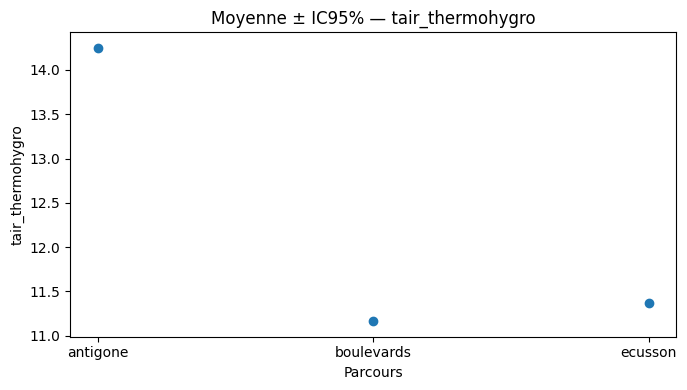

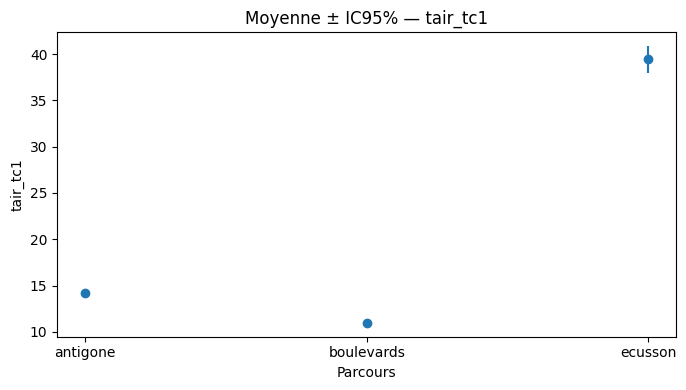

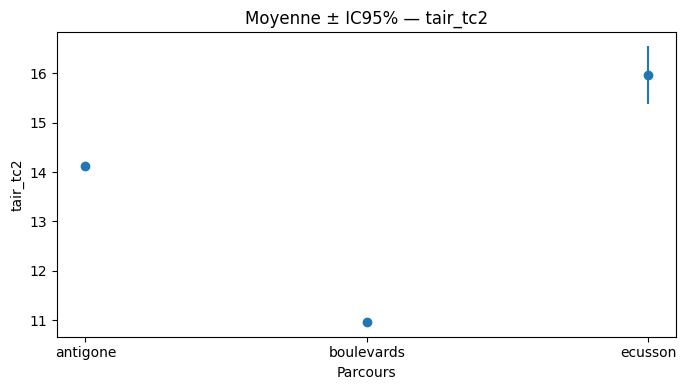

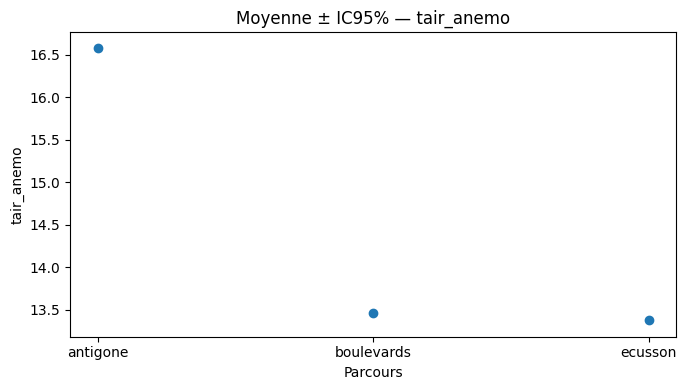

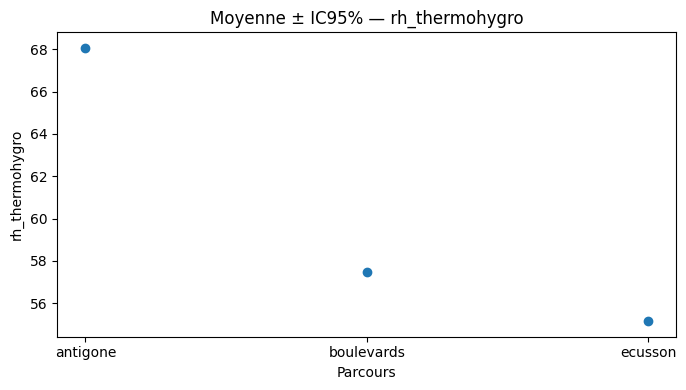

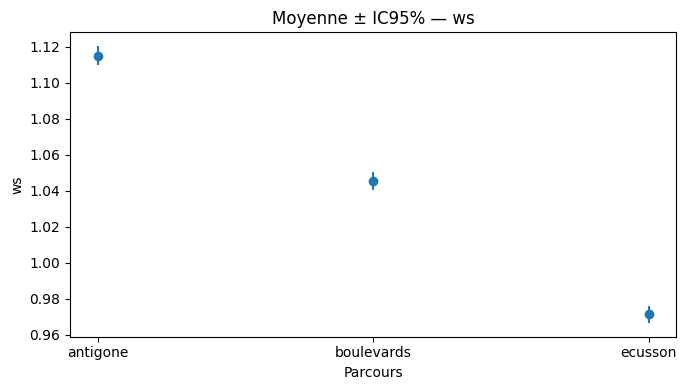

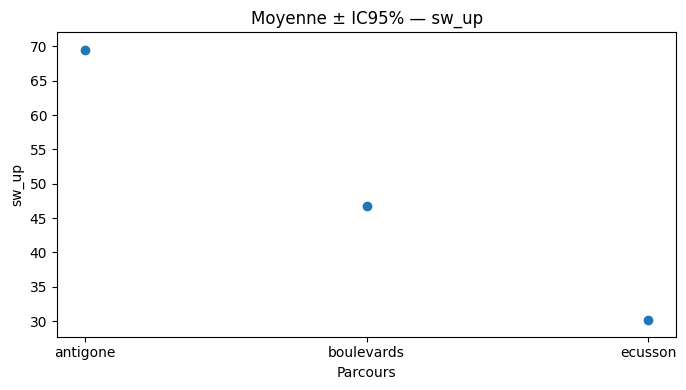

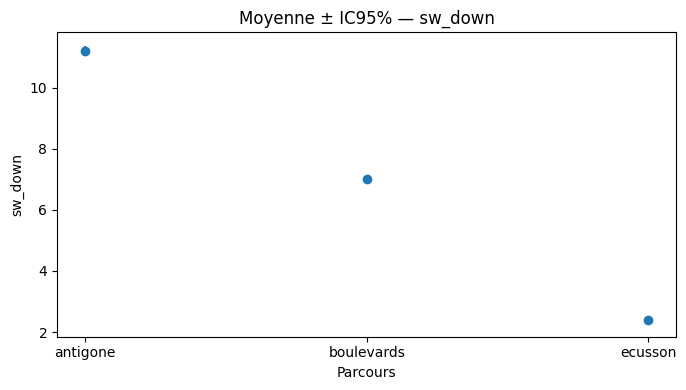

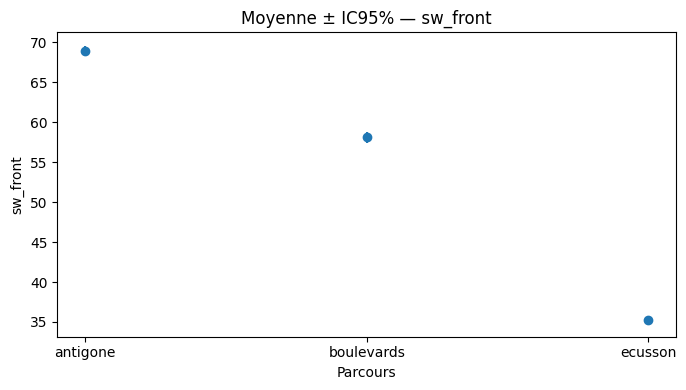

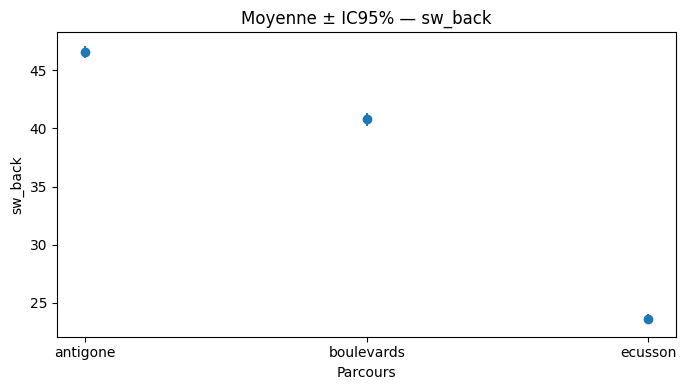

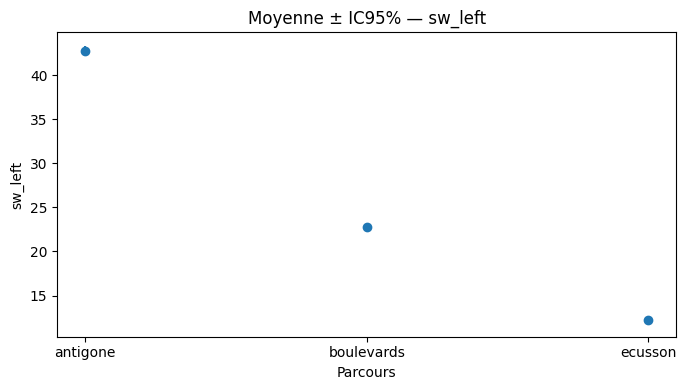

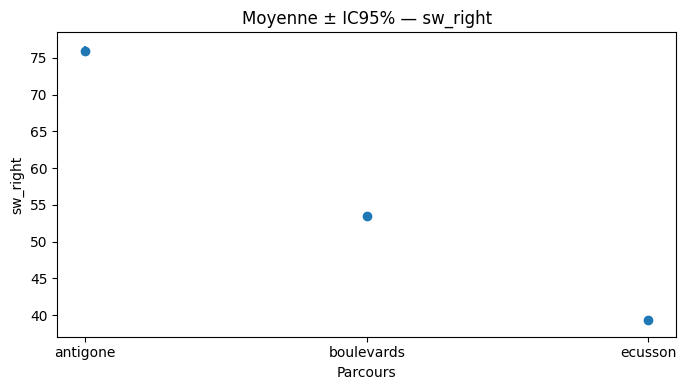

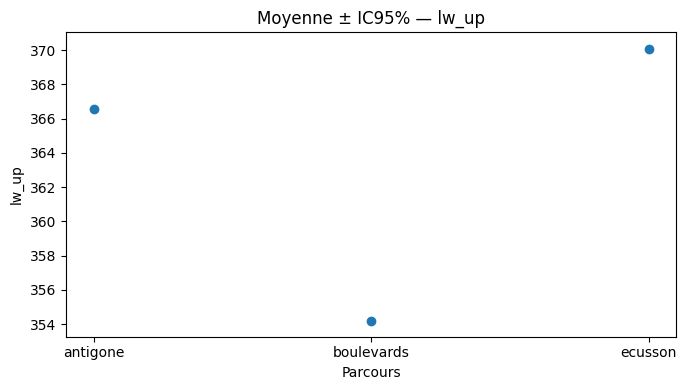

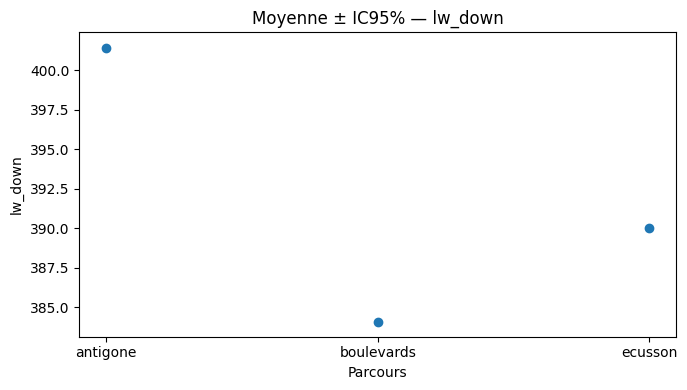

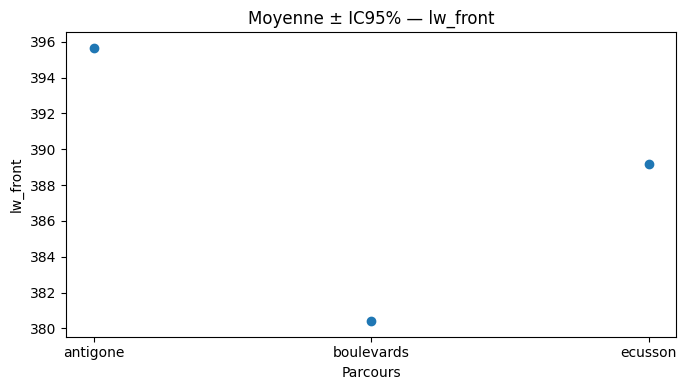

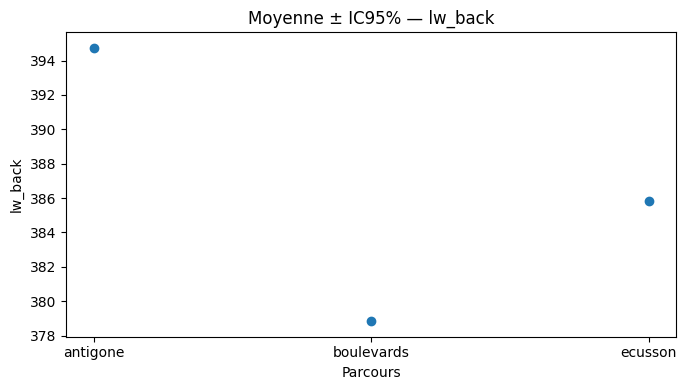

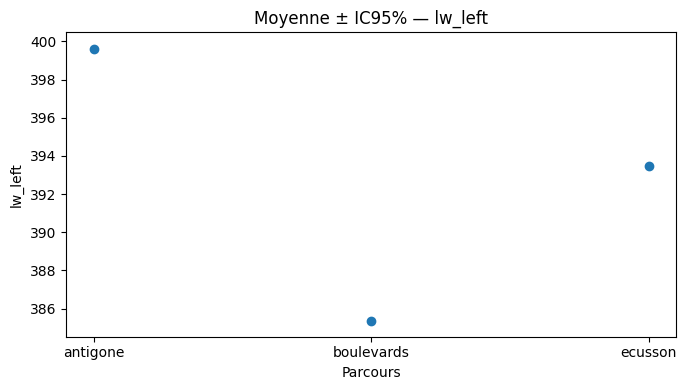

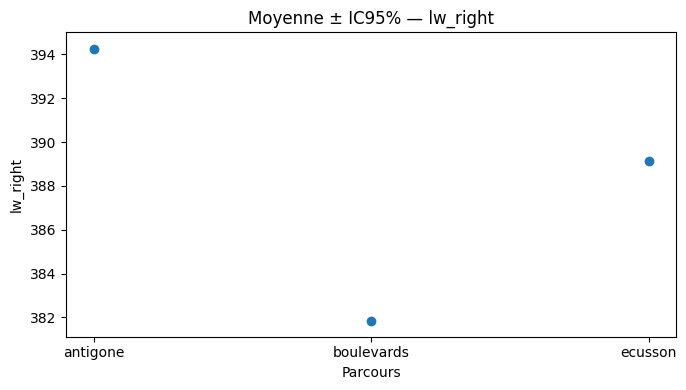

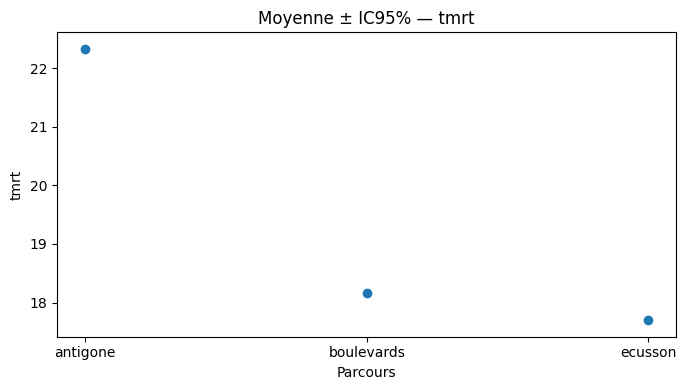

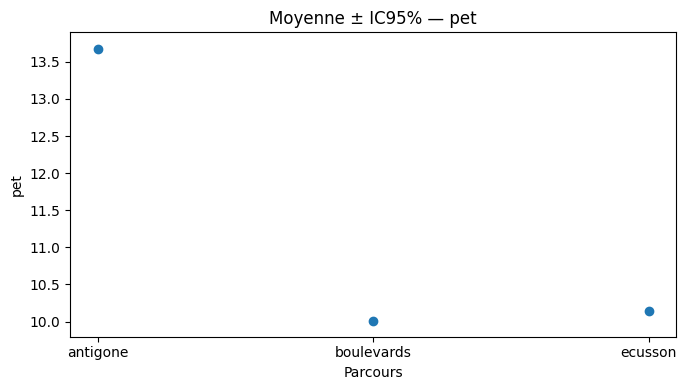

In [101]:
g = raw.groupby("track_id")[num_cols].agg(["mean","std","count"])
for v in num_cols:
    m = g[(v,"mean")]; se = g[(v,"std")] / np.sqrt(g[(v,"count")]); ic = 1.96*se
    plt.figure(figsize=(7,4))
    plt.errorbar(m.index.astype(str), m.values, yerr=ic.values, fmt="o")
    plt.title(f"Moyenne ± IC95% — {v}")
    plt.xlabel("Parcours"); plt.ylabel(v)
    plt.tight_layout(); plt.savefig(FIG_DIR/f"mean_ic_{v}_parcours.png", dpi=150); plt.show()


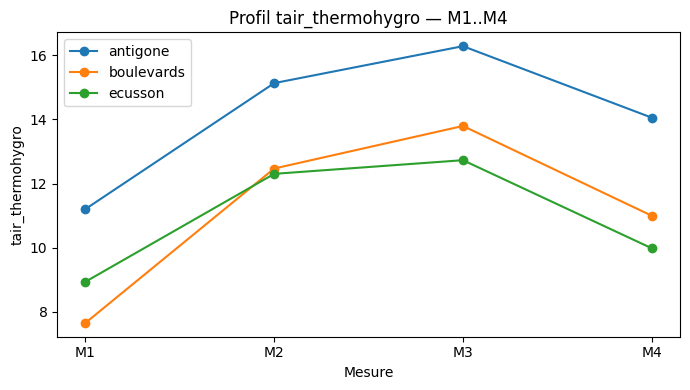

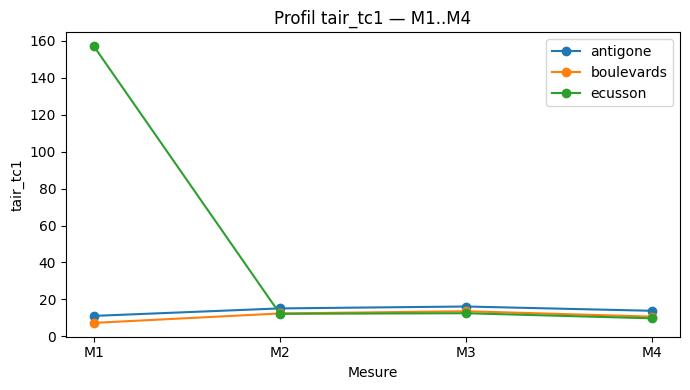

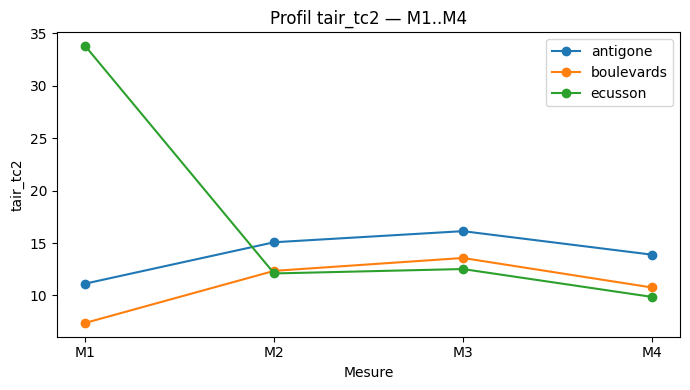

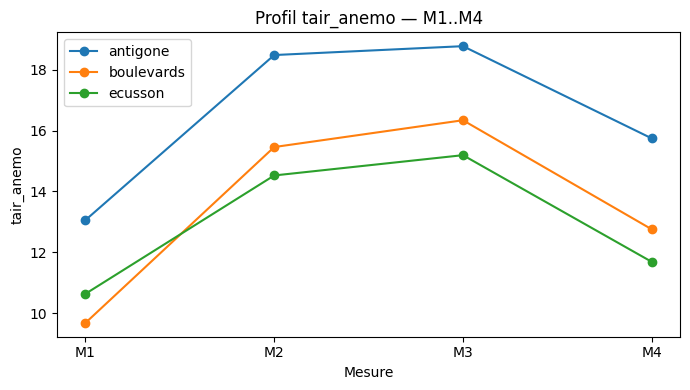

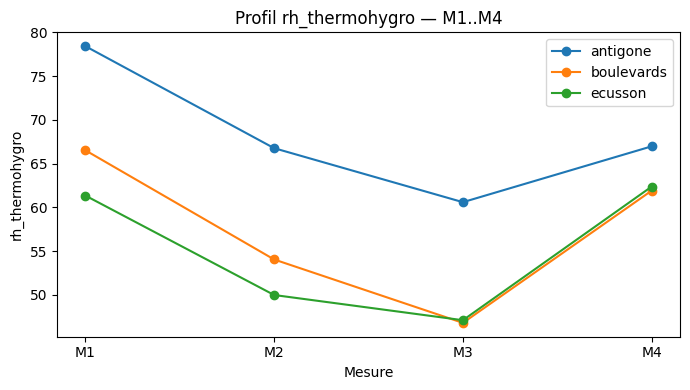

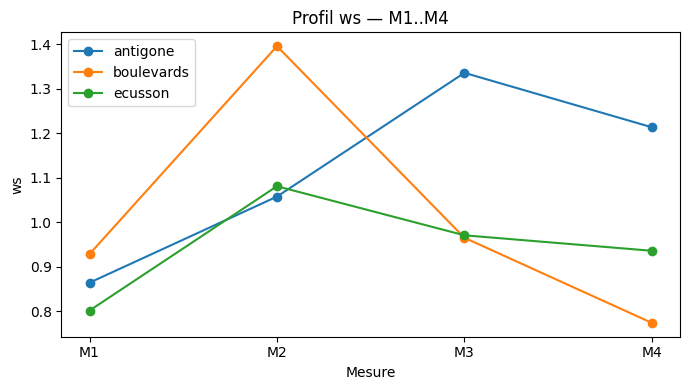

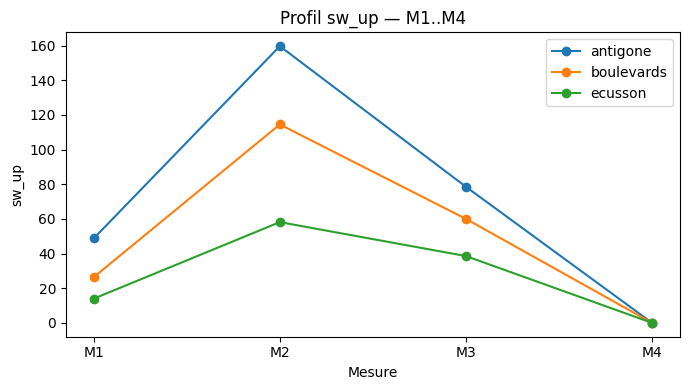

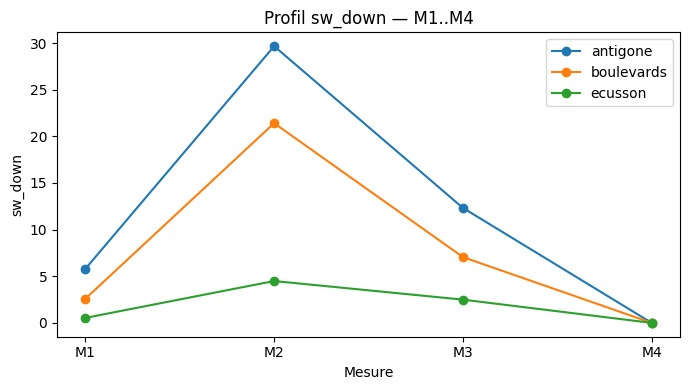

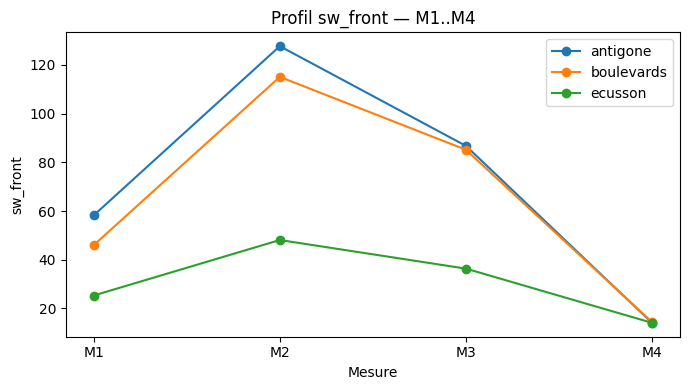

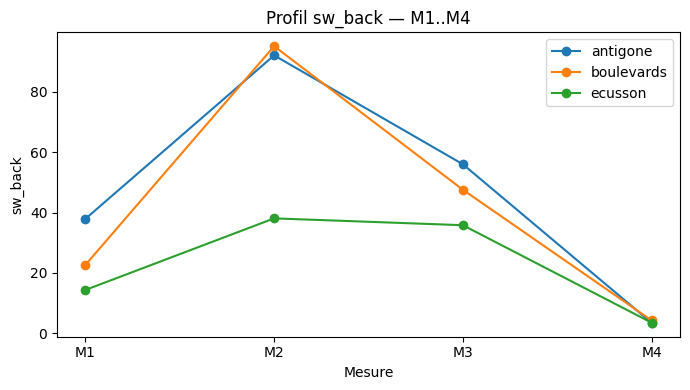

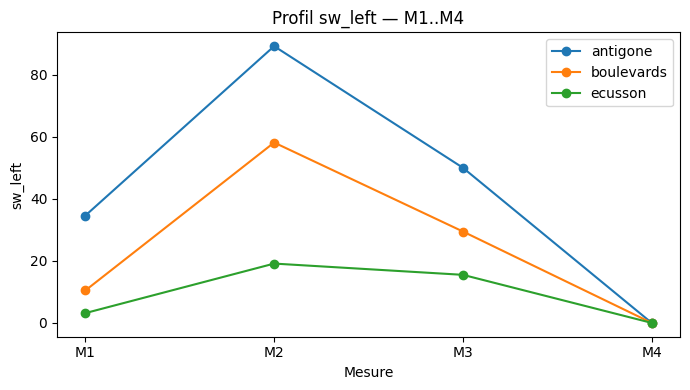

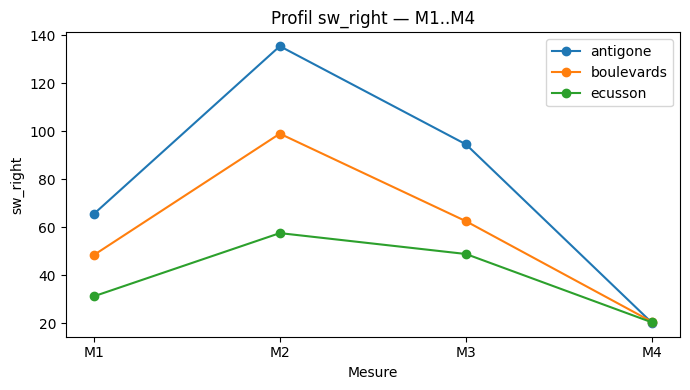

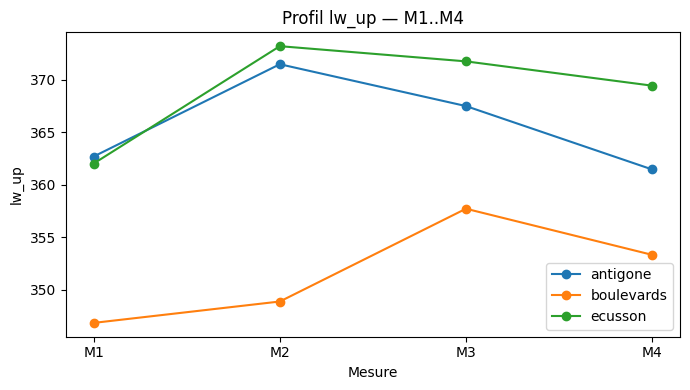

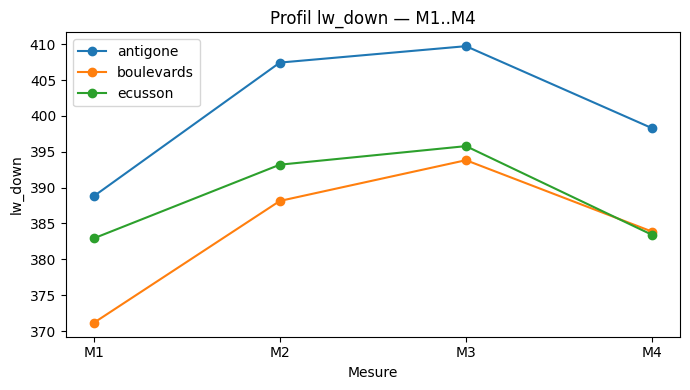

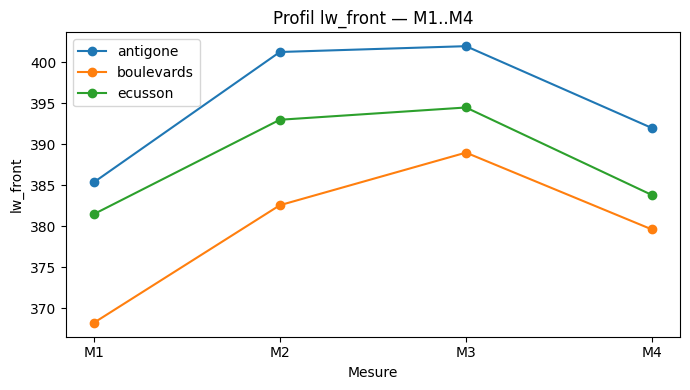

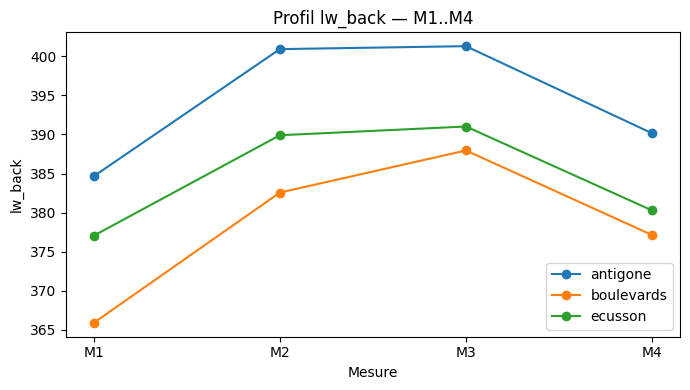

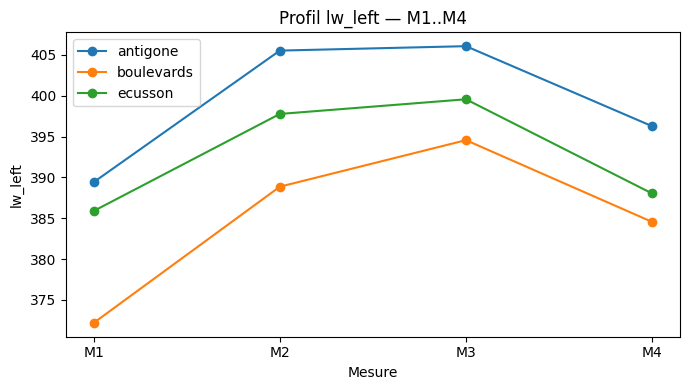

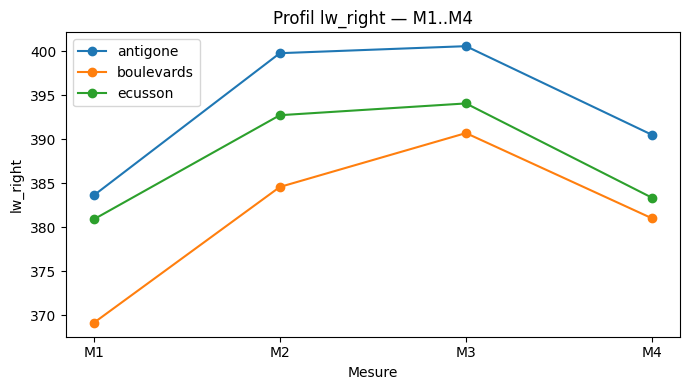

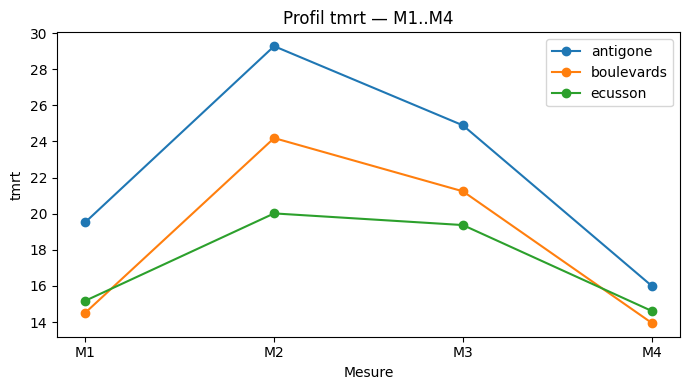

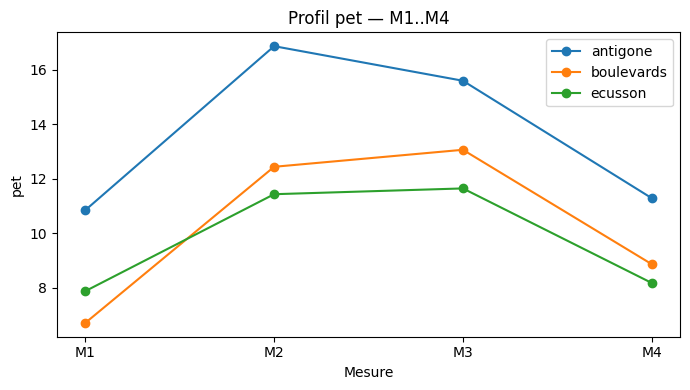

In [102]:
order = ["M1","M2","M3","M4"]
agg = raw.groupby(["track_id","M_slot"])[num_cols].mean().reset_index()
tracks_focus = ["antigone","boulevards","ecusson"]
for v in num_cols:
    plt.figure(figsize=(7,4))
    for t in tracks_focus:
        gg = agg[agg.track_id==t].set_index("M_slot").reindex(order)[v]
        if gg.isna().all(): continue
        plt.plot(order, gg.values, marker="o", label=t)
    plt.title(f"Profil {v} — M1..M4")
    plt.xlabel("Mesure"); plt.ylabel(v); plt.legend()
    plt.tight_layout(); plt.savefig(FIG_DIR/f"profile_{v}_Mslots.png", dpi=150); plt.show()


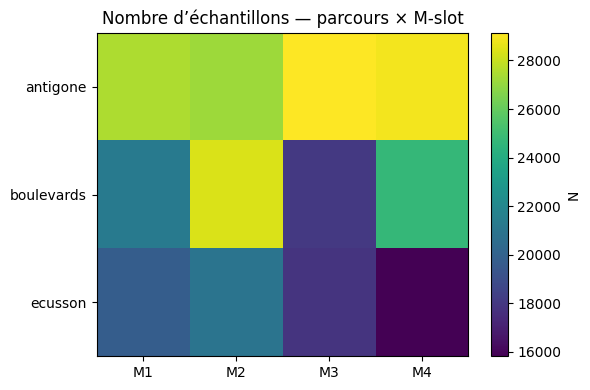

In [103]:
tab = (raw.dropna(subset=["track_id","M_slot"])
          .pivot_table(index="track_id", columns="M_slot",
                       values="timestamp", aggfunc="count", observed=True)
          .reindex(columns=["M1","M2","M3","M4"]).fillna(0))
plt.figure(figsize=(6,4))
plt.imshow(tab.values, aspect="auto")
plt.xticks(range(tab.shape[1]), tab.columns); plt.yticks(range(tab.shape[0]), tab.index)
plt.title("Nombre d’échantillons — parcours × M-slot")
plt.colorbar(label="N")
plt.tight_layout(); plt.savefig(FIG_DIR/"heatmap_counts_parcours_M.png", dpi=150); plt.show()


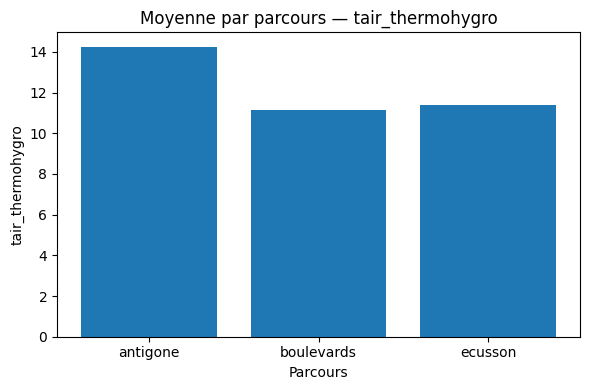

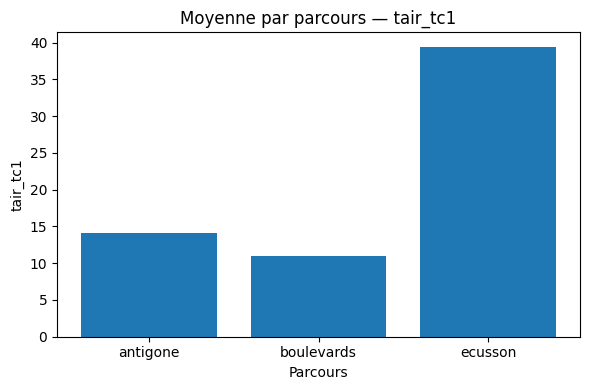

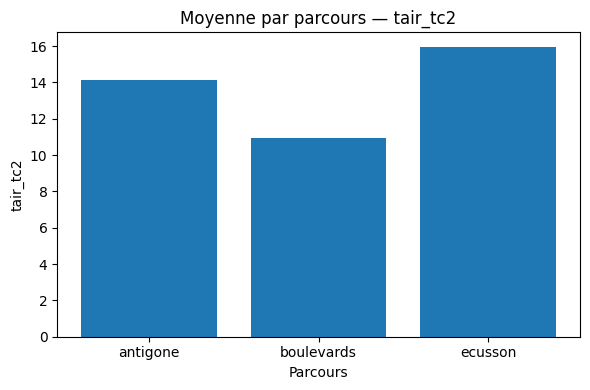

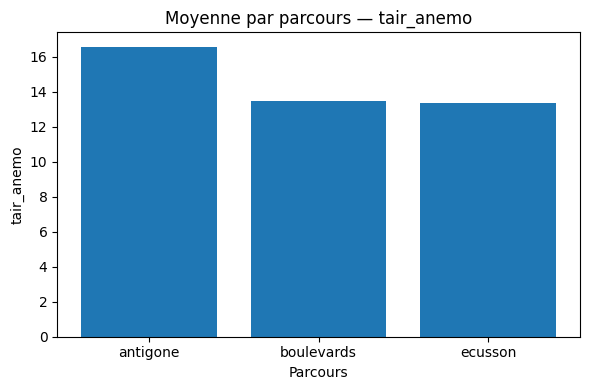

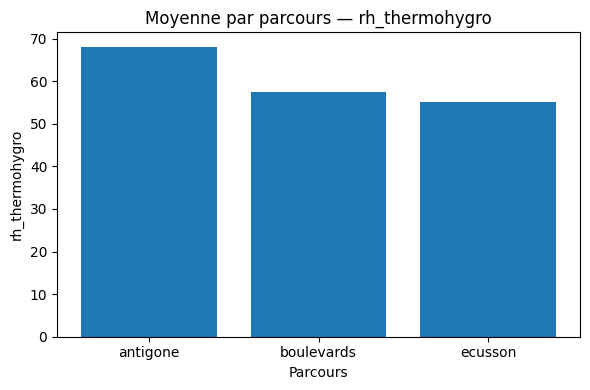

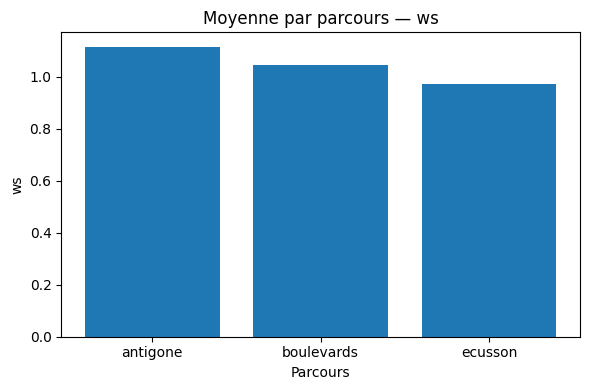

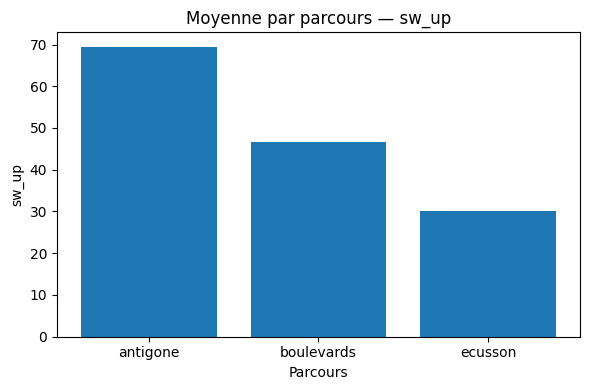

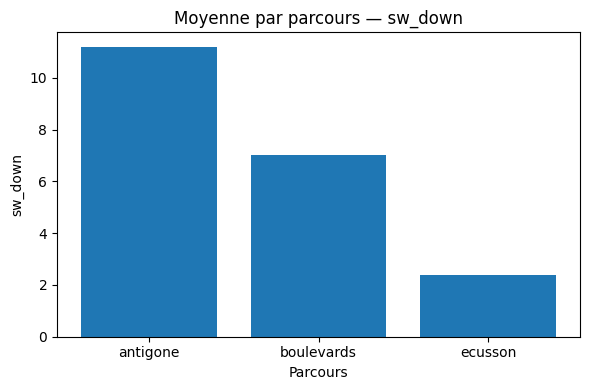

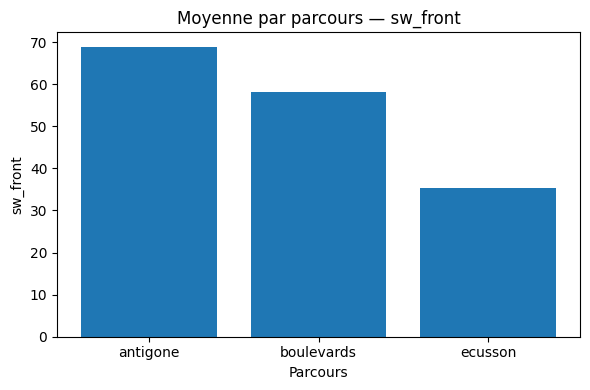

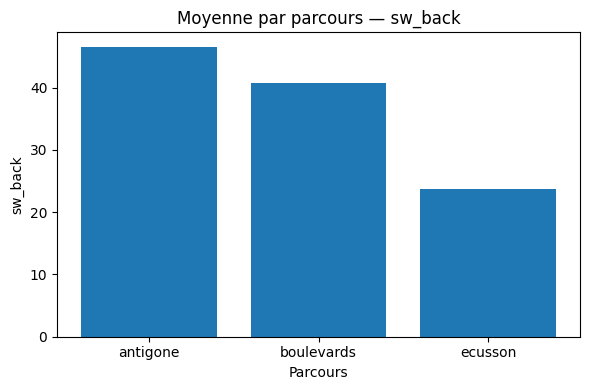

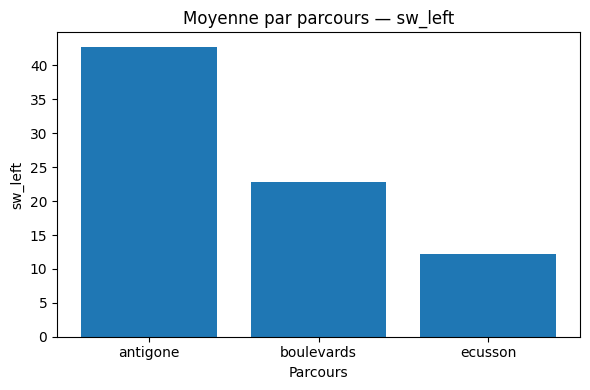

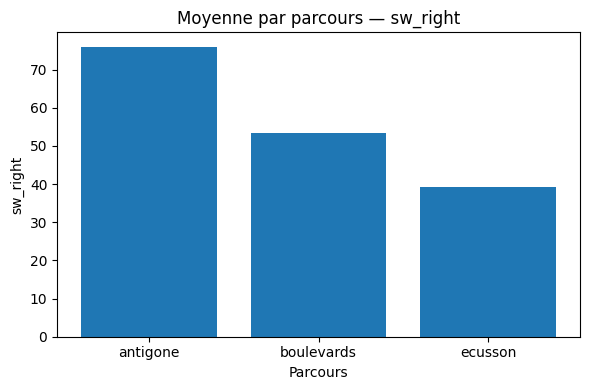

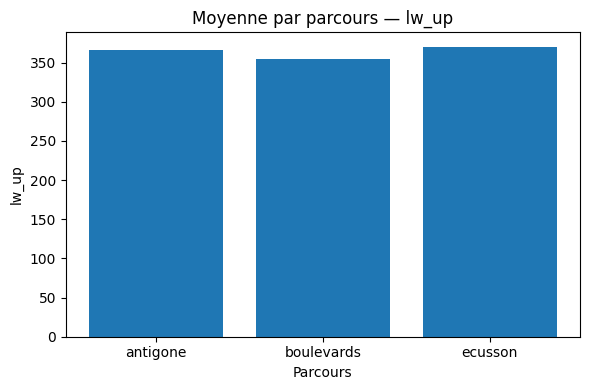

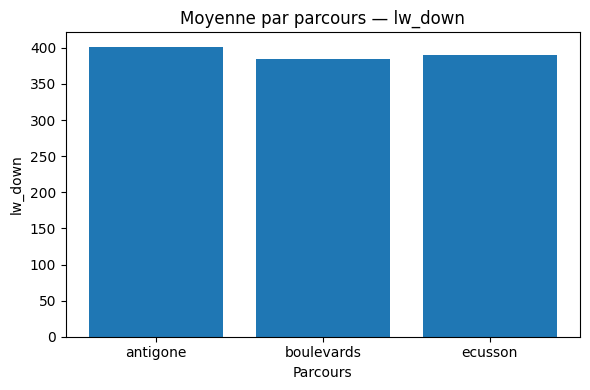

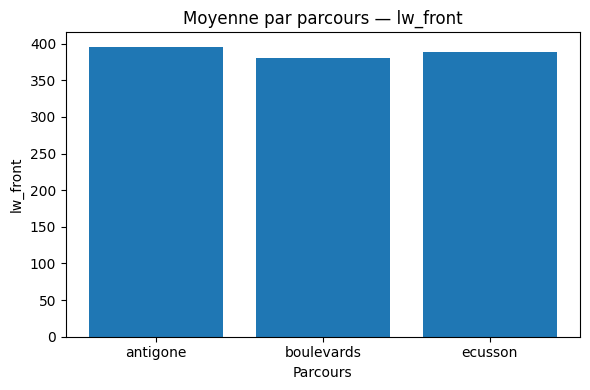

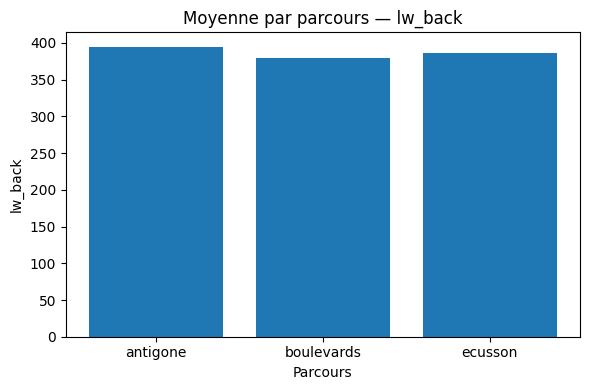

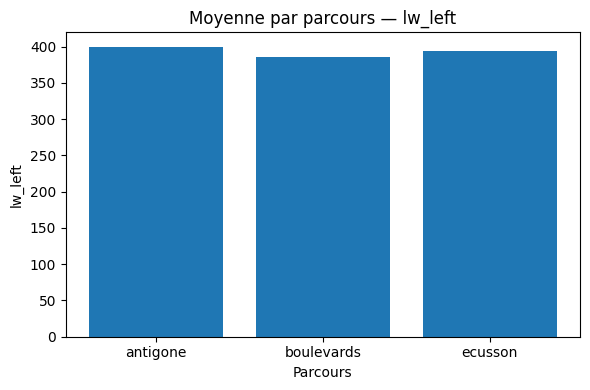

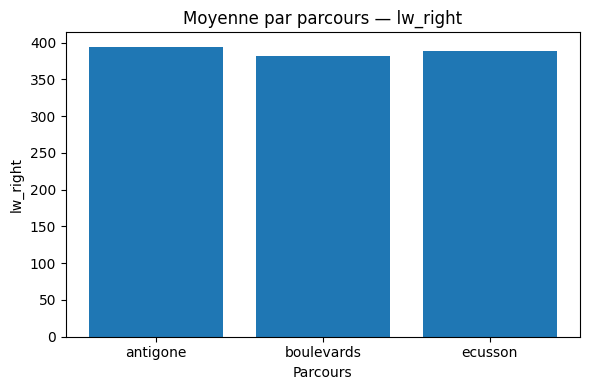

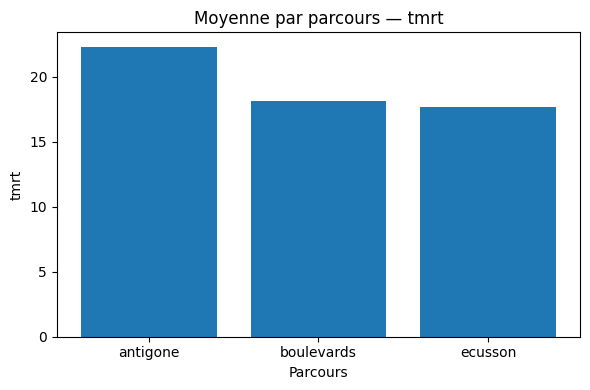

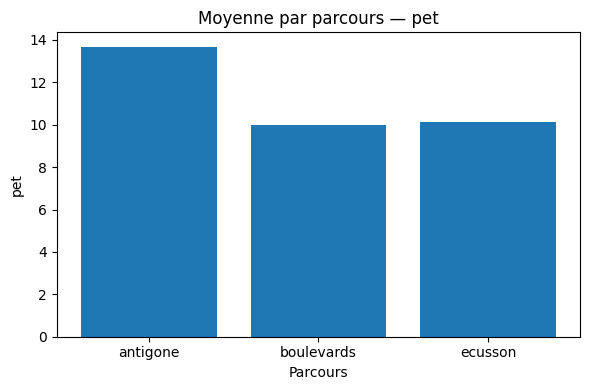

In [104]:
comp = raw[raw["track_id"].isin(["antigone","boulevards","ecusson"])] \
          .groupby("track_id")[num_cols].mean().T
for v in comp.index:
    plt.figure(figsize=(6,4))
    plt.bar(comp.columns.astype(str), comp.loc[v].values)
    plt.title(f"Moyenne par parcours — {v}")
    plt.xlabel("Parcours"); plt.ylabel(v)
    plt.tight_layout(); plt.savefig(FIG_DIR/f"bar_mean_{v}_parcours.png", dpi=150); plt.show()


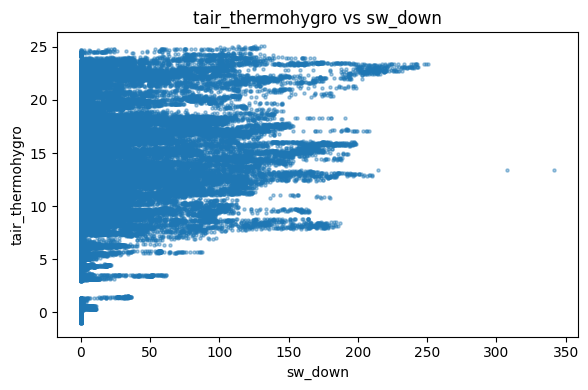

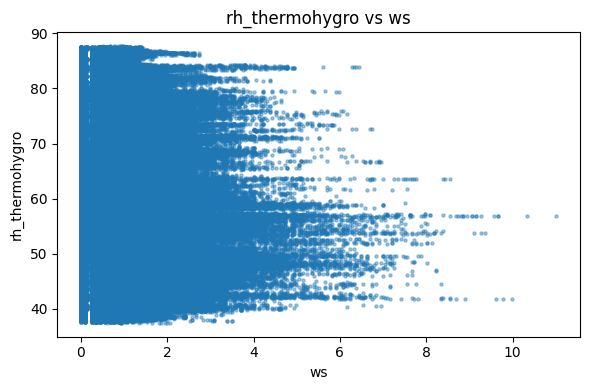

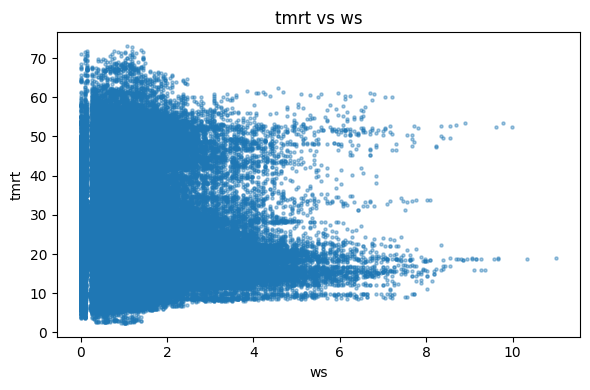

In [105]:
pairs = [("sw_down","tair_thermohygro"), ("ws","rh_thermohygro"), ("ws","tmrt")]
for x,y in pairs:
    if x in METEO and y in METEO:
        plt.figure(figsize=(6,4))
        plt.scatter(raw[x], raw[y], s=5, alpha=0.4)
        plt.title(f"{y} vs {x}")
        plt.xlabel(x); plt.ylabel(y)
        plt.tight_layout(); plt.savefig(FIG_DIR/f"scatter_{y}_vs_{x}.png", dpi=150); plt.show()


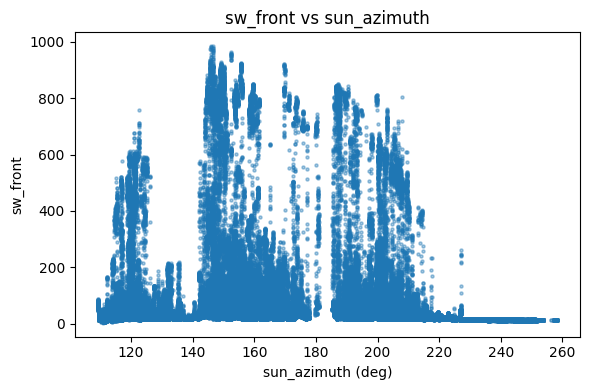

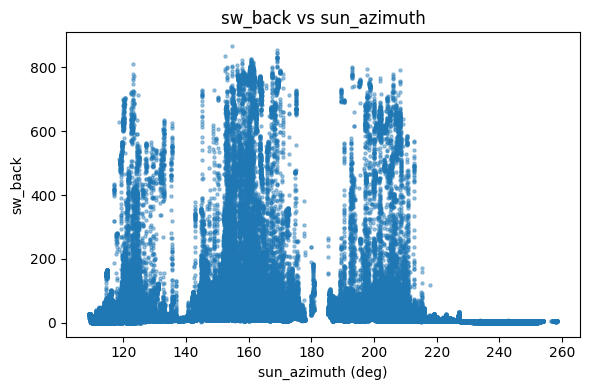

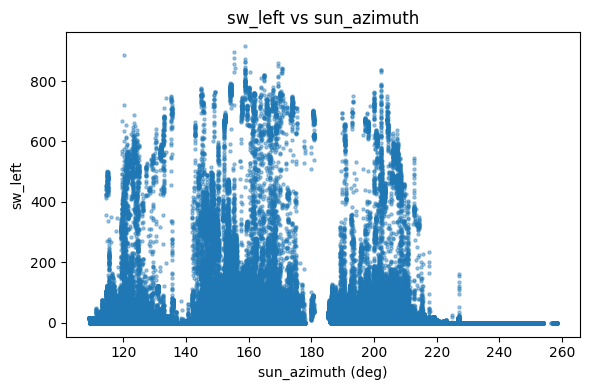

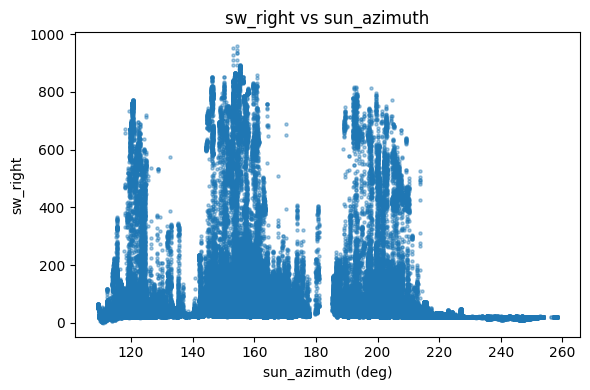

In [106]:
for face in [c for c in ["sw_front","sw_back","sw_left","sw_right"] if c in METEO]:
    if "sun_azimuth" not in raw.columns: break
    plt.figure(figsize=(6,4))
    plt.scatter(raw["sun_azimuth"], raw[face], s=5, alpha=0.4)
    plt.title(f"{face} vs sun_azimuth"); plt.xlabel("sun_azimuth (deg)"); plt.ylabel(face)
    plt.tight_layout(); plt.savefig(FIG_DIR/f"sun_{face}.png", dpi=150); plt.show()


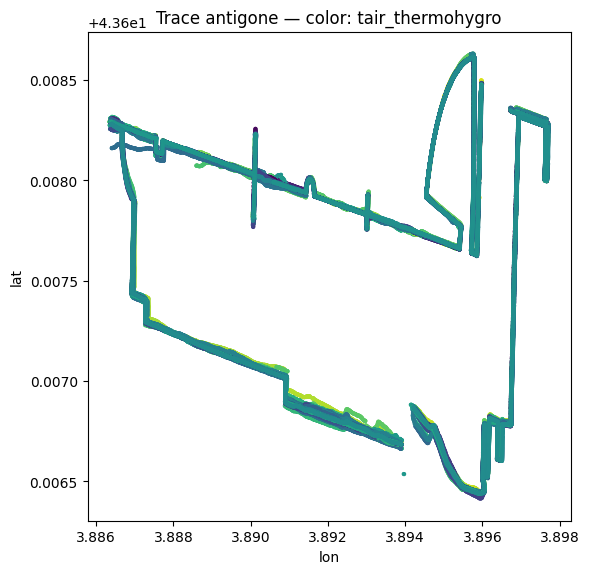

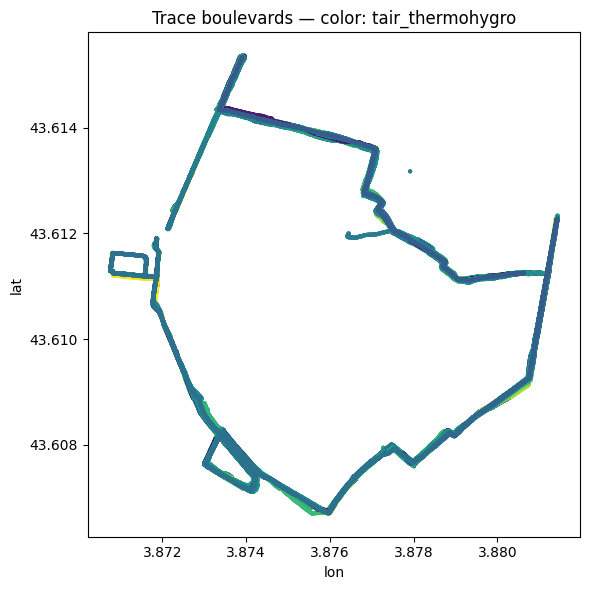

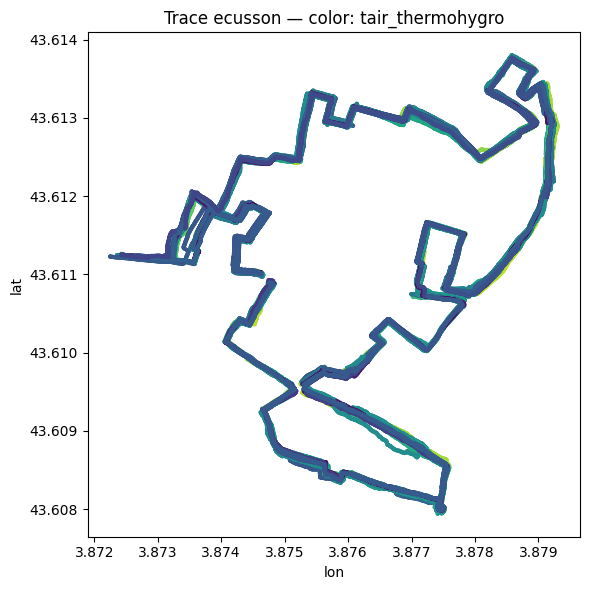

In [107]:
if {"lat","lon"}.issubset(raw.columns) and "tair_thermohygro" in raw.columns:
    for t,g in raw.groupby("track_id"):
        s = g.dropna(subset=["lat","lon","tair_thermohygro"])
        if s.empty: continue
        plt.figure(figsize=(6,6))
        plt.scatter(s["lon"], s["lat"], c=s["tair_thermohygro"], s=4)
        plt.title(f"Trace {t} — color: tair_thermohygro")
        plt.xlabel("lon"); plt.ylabel("lat")
        plt.tight_layout(); plt.savefig(FIG_DIR/f"map_tair_{t}.png", dpi=150); plt.show()
